# Contents
* [Introduction](#Introduction)
* [Imports and configuration](#Imports-and-configuration)
* [Setup](#Setup)
* [Score models](#Score-models)
* [Results](#Results)
* [Discussion](#Discussion)

# Introduction

This notebook examines the efficacy of LDA components as features.

# Imports and configuration

In [1]:
from time import time

notebook_begin_time = time()

# set random seeds

from os import environ
from random import seed as random_seed
from numpy.random import seed as np_seed
from tensorflow.random import set_seed


def reset_seeds(seed: int) -> None:
    """Utility function for resetting random seeds"""
    environ["PYTHONHASHSEED"] = str(seed)
    random_seed(seed)
    np_seed(seed)
    set_seed(seed)


reset_seeds(SEED := 2021)
del environ
del random_seed
del np_seed
del set_seed
del reset_seeds

In [2]:
# extensions
%load_ext autotime
%load_ext lab_black
%load_ext nb_black

In [3]:
# core
import numpy as np
import pandas as pd

# utility
from collections import namedtuple
from gc import collect as gc_collect
from tqdm.notebook import tqdm

# typing
from typing import Any, Dict, List

# faster pandas & sklearn
import swifter
from sklearnex import patch_sklearn

patch_sklearn()
del patch_sklearn

# metrics
from imblearn.metrics import geometric_mean_score
from sklearn.metrics import (
    accuracy_score,
    balanced_accuracy_score,
    f1_score,
    roc_auc_score,
)

# other sklearn
from sklearn.calibration import CalibratedClassifierCV
from sklearn.linear_model import (
    LogisticRegressionCV,
    RidgeClassifierCV,
    SGDClassifier,
)
from sklearn.model_selection import RandomizedSearchCV
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import LinearSVC, SVC

# visualization
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_context("notebook")
%matplotlib inline

# display outputs w/o print calls
from IPython.core.interactiveshell import InteractiveShell

InteractiveShell.ast_node_interactivity = "all"
del InteractiveShell

# hide warnings
import warnings

warnings.filterwarnings("ignore")
del warnings

Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)


time: 3.44 s


In [4]:
# Location of cross validation data
FRILL_FEATHERS_FOLDER = "../10.0-mic-prepare_train-test_splits_on_full_data"

# Location where this notebook will output
DATA_OUT_FOLDER = "."

_ = gc_collect()

time: 122 ms


# Setup

In this section, we define some structures to keep track of models and scores.

In [5]:
MODELS = {
    "GaussianNB": lambda: GaussianNB(),
    "GaussianNB_acc": lambda: RandomizedSearchCV(
        estimator=GaussianNB(),
        param_distributions={"var_smoothing": np.logspace(-2, -10, num=200)},
        n_iter=100,
        scoring="accuracy",
        n_jobs=-1,
        verbose=2,
        random_state=SEED,
    ),
    "GaussianNB_balacc": lambda: RandomizedSearchCV(
        estimator=GaussianNB(),
        param_distributions={"var_smoothing": np.logspace(-2, -10, num=200)},
        n_iter=100,
        scoring="balanced_accuracy",
        n_jobs=-1,
        verbose=2,
        random_state=SEED,
    ),
    "GaussianNB_f1": lambda: RandomizedSearchCV(
        estimator=GaussianNB(),
        param_distributions={"var_smoothing": np.logspace(-2, -10, num=200)},
        n_iter=100,
        scoring="f1_weighted",
        n_jobs=-1,
        verbose=2,
        random_state=SEED,
    ),
    "GaussianNB_iso-calib": lambda: CalibratedClassifierCV(
        base_estimator=GaussianNB(), method="isotonic"
    ),
    "GaussianNB_sig-calib": lambda: CalibratedClassifierCV(
        base_estimator=GaussianNB(), method="sigmoid"
    ),
    "LinearSVC": lambda: LinearSVC(random_state=SEED),
    "LinearSVC_b": lambda: LinearSVC(class_weight="balanced", random_state=SEED),
    "LinearSVC_iso-calib": lambda: CalibratedClassifierCV(
        base_estimator=LinearSVC(random_state=SEED), method="isotonic"
    ),
    "LinearSVC_sig-calib": lambda: CalibratedClassifierCV(
        base_estimator=LinearSVC(random_state=SEED), method="sigmoid"
    ),
    "LinearSVC_b_iso-calib": lambda: CalibratedClassifierCV(
        base_estimator=LinearSVC(class_weight="balanced", random_state=SEED),
        method="isotonic",
    ),
    "LinearSVC_b_sig-calib": lambda: CalibratedClassifierCV(
        base_estimator=LinearSVC(class_weight="balanced", random_state=SEED),
        method="sigmoid",
    ),
    "LogRegCV_acc": lambda: LogisticRegressionCV(
        scoring="accuracy",
        n_jobs=-1,
        verbose=1,
        random_state=SEED,
    ),
    "LogRegCV_balacc": lambda: LogisticRegressionCV(
        scoring="balanced_accuracy",
        n_jobs=-1,
        verbose=1,
        random_state=SEED,
    ),
    "LogRegCV_f1": lambda: LogisticRegressionCV(
        scoring="f1_weighted",
        n_jobs=-1,
        verbose=1,
        random_state=SEED,
    ),
    "LogRegCV_b_acc": lambda: LogisticRegressionCV(
        scoring="accuracy",
        class_weight="balanced",
        n_jobs=-1,
        verbose=1,
        random_state=SEED,
    ),
    "LogRegCV_b_balacc": lambda: LogisticRegressionCV(
        scoring="balanced_accuracy",
        class_weight="balanced",
        n_jobs=-1,
        verbose=1,
        random_state=SEED,
    ),
    "LogRegCV_b_f1": lambda: LogisticRegressionCV(
        scoring="f1_weighted",
        class_weight="balanced",
        n_jobs=-1,
        verbose=1,
        random_state=SEED,
    ),
    "RidgeCV_acc": lambda: RidgeClassifierCV(
        scoring="accuracy", class_weight="balanced"
    ),
    "RidgeCV_balacc": lambda: RidgeClassifierCV(
        scoring="balanced_accuracy", class_weight="balanced"
    ),
    "RidgeCV_f1": lambda: RidgeClassifierCV(
        scoring="f1_weighted", class_weight="balanced"
    ),
    "RidgeCV_b_acc": lambda: RidgeClassifierCV(
        scoring="accuracy", class_weight="balanced"
    ),
    "RidgeCV_b_balacc": lambda: RidgeClassifierCV(
        scoring="balanced_accuracy", class_weight="balanced"
    ),
    "RidgeCV_b_f1": lambda: RidgeClassifierCV(
        scoring="f1_weighted", class_weight="balanced"
    ),
    "SGD": lambda: SGDClassifier(n_jobs=-1, random_state=SEED),
    "SGD_b": lambda: SGDClassifier(
        n_jobs=-1, random_state=SEED, class_weight="balanced"
    ),
    "SGD_iso-calib": lambda: CalibratedClassifierCV(
        base_estimator=SGDClassifier(n_jobs=-1, random_state=SEED), method="isotonic"
    ),
    "SGD_sig-calib": lambda: CalibratedClassifierCV(
        base_estimator=SGDClassifier(n_jobs=-1, random_state=SEED), method="sigmoid"
    ),
    "SGD_b_iso-calib": lambda: CalibratedClassifierCV(
        base_estimator=SGDClassifier(
            n_jobs=-1, random_state=SEED, class_weight="balanced"
        ),
        method="isotonic",
    ),
    "SGD_b_sig-calib": lambda: CalibratedClassifierCV(
        base_estimator=SGDClassifier(
            n_jobs=-1, random_state=SEED, class_weight="balanced"
        ),
        method="sigmoid",
    ),
    "SVC": lambda: SVC(random_state=SEED),
    "SVC_iso-calib": lambda: CalibratedClassifierCV(
        base_estimator=SVC(random_state=SEED), method="isotonic"
    ),
    "SVC_sig-calib": lambda: CalibratedClassifierCV(
        base_estimator=SVC(random_state=SEED), method="sigmoid"
    ),
}

_ = gc_collect()

time: 109 ms


In [6]:
METRICS = (
    "accuracy",
    "adjusted_balanced_accuracy",
    "balanced_accuracy",
    "f1",
    "geometric_mean",
    "roc_auc",
    "fit_time",
    "predict_time",
)

# to be cast to pd.DataFrame
make_results = lambda: {
    key: [] for key in {"model_name", "case", "preprocessing", *METRICS}
}
results_ = make_results()

AvgScores = namedtuple("AvgScores", METRICS)


def store_result(
    where: Dict[str, List],
    model_name: str,
    case: str,
    preprocessing: str,
    avg_scores: AvgScores,
) -> None:
    "Appends a model's scores and fit/predict times to the results dict."
    for attribute, value in {
        "model_name": model_name,
        "case": case,
        "preprocessing": preprocessing,
        **avg_scores._asdict(),
    }.items():
        where[attribute].append(value)


def create_results_df(results_dict: Dict[str, List]) -> pd.DataFrame:
    """Create a results dataframe from the results dictionary"""
    df = (
        pd.DataFrame(results_dict)
        .sort_values(by=["preprocessing", "model_name"], ascending=True)
        .sort_values(by=["fit_time", "predict_time"], ascending=True)
        .sort_values(
            by=[
                "accuracy",
                "adjusted_balanced_accuracy",
                "balanced_accuracy",
                "geometric_mean",
                "f1",
                "roc_auc",
            ],
            ascending=False,
        )
        .sort_values(by=["case"], ascending=True)
        .reset_index(drop=True)
    )[
        [  # selection order
            "model_name",
            "case",
            "preprocessing",
            "accuracy",
            "adjusted_balanced_accuracy",
            "balanced_accuracy",
            "f1",
            "geometric_mean",
            "roc_auc",
            "fit_time",
            "predict_time",
        ]
    ]
    df.loc[:, "case"] = df.loc[:, "case"].astype("category")
    df.loc[:, "preprocessing"] = df.loc[:, "preprocessing"].astype("category")
    return df


ALL_CASES = {"ternary"}

_ = gc_collect()

time: 123 ms


In [7]:
predictions_ = {key: [] for key in {"model", "case", "preprocessing", "fold", "y_pred"}}

Prediction = namedtuple("Prediction", predictions_.keys())


def store_prediction(where: Dict[str, List], prediction: Prediction) -> None:
    "Records the y_pred of a classifier on a fold"
    for k, v in prediction._asdict().items():
        where[k].append(v)


_ = gc_collect()

time: 118 ms


In [8]:
def print_and_append(to_append: Any, append_to: List[Any]) -> List[Any]:
    """Given an object and a list, pass the object to print() and then append it to the list, which is returned"""
    print(to_append)
    append_to.append(to_append)
    return append_to


def prep_y_pred(label: int) -> np.ndarray:
    """Prepares labels for AUROC scoring"""
    _ = [0, 0, 0]
    _[label] = 1
    return np.asarray(_, dtype=np.float64)


def evaluate_model(
    model_base: str,
    case: str = "ternary",
    preprocessing: str = "untransformed",
    track_fold_time: bool = True,
) -> AvgScores:
    """Evaluate a model with cross validation on prepared folds."""
    (
        fit_times,
        predict_times,
        accuracy,
        adjusted_balanced_accuracy,
        balanced_accuracy,
        f1,
        geometric_mean,
        roc_auc,
    ) = ([] for _ in range(8))
    fold_num = 0
    while True:
        if track_fold_time:
            fold_begin = time()
        # load training data
        read_feather_cv = lambda filename: pd.read_feather(
            f"{FRILL_FEATHERS_FOLDER}/cv_{fold_num}/{filename}.feather"
        )
        resampled_LDA = "resampled" in preprocessing
        try:
            X_train = read_feather_cv(
                f"X_train_{'resampled_' if resampled_LDA else ''}LDA"
            )
            y_train = read_feather_cv(
                f"y_train_{'resampled_ter' if resampled_LDA else 'untransformed'}"
            ).iloc[:, 0]
        except FileNotFoundError:
            break

        # initialize model
        model = MODELS[model_base]()

        # fit
        begin = time()
        model.fit(X_train, y_train)
        end = time()
        del X_train
        del y_train
        _ = gc_collect()
        fit_times.append(end - begin)
        print(f"fitted in {end - begin:.2f} s")

        try:
            print("best score: ", model.best_score_)
            print(model.best_params_)
        except AttributeError:
            pass

        # load test data
        X_test = read_feather_cv(f"X_test_{'resampled_' if resampled_LDA else ''}LDA")

        # predict
        begin = time()
        predicted = model.predict(X_test)
        end = time()
        try:
            proba_predict = model.predict_proba(X_test)
        except AttributeError:
            # some classifiers do not support .predict_proba
            proba_predict = np.stack(pd.Series(predicted).swifter.apply(prep_y_pred))
        del X_test
        del model
        _ = gc_collect()
        predict_times.append(end - begin)
        print(f"predicted in {end - begin:.2f} s")
        del end
        del begin
        _ = gc_collect()
        store_prediction(
            where=predictions_,
            prediction=Prediction(
                model=model_base,
                case=case,
                preprocessing=preprocessing,
                fold=fold_num,
                y_pred=proba_predict,
            ),
        )

        # score
        score_params = {
            "y_true": read_feather_cv(
                f"y_test_{'ter' if resampled_LDA else 'untransformed'}"
            ).iloc[:, 0],
            "y_pred": predicted,
        }
        del resampled_LDA
        _ = gc_collect()
        print("accuracy: ", end="")
        accuracy = print_and_append(
            to_append=accuracy_score(**score_params), append_to=accuracy
        )
        print("adjusted balanced accuracy: ", end="")
        adjusted_balanced_accuracy = print_and_append(
            to_append=balanced_accuracy_score(**score_params, adjusted=True),
            append_to=adjusted_balanced_accuracy,
        )
        print("balanced accuracy: ", end="")
        balanced_accuracy = print_and_append(
            to_append=balanced_accuracy_score(**score_params),
            append_to=balanced_accuracy,
        )
        print("f1: ", end="")
        f1 = print_and_append(
            to_append=f1_score(**score_params, average="weighted"), append_to=f1
        )
        print("geometric mean: ", end="")
        geometric_mean = print_and_append(
            to_append=geometric_mean_score(**score_params), append_to=geometric_mean
        )
        print("roc auc: ", end="")
        roc_auc = print_and_append(
            to_append=roc_auc_score(
                y_true=score_params["y_true"],
                y_score=proba_predict,
                average="weighted",
                multi_class="ovo",
            ),
            append_to=roc_auc,
        )
        del score_params
        del predicted
        del proba_predict
        _ = gc_collect()

        if track_fold_time:
            print(
                f"{model_base} fold {fold_num + 1} completed in {time() - fold_begin:.2f} s"
            )
            del fold_begin

        fold_num += 1
        _ = gc_collect()

    return AvgScores(
        *[
            np.mean(_)
            for _ in (
                accuracy,
                adjusted_balanced_accuracy,
                balanced_accuracy,
                f1,
                geometric_mean,
                roc_auc,
                fit_times,
                predict_times,
            )
        ]
    )


case = "ternary"

_ = gc_collect()

time: 121 ms


# Score models

In [9]:
for model in tqdm(MODELS):
    for preprocessing in {"LDA", "resampled_LDA"}:
        print(f"evaluating {model}...")
        eval_begin = time()
        store_result(
            where=results_,
            model_name=model,
            case="ternary",
            preprocessing=preprocessing,
            avg_scores=evaluate_model(model_base=model, preprocessing=preprocessing),
        )
        print(f"stored {model} in {time() - eval_begin:.2f} s")
        del eval_begin
        _ = gc_collect()

  0%|          | 0/33 [00:00<?, ?it/s]

evaluating GaussianNB...
fitted in 0.27 s
predicted in 0.02 s
accuracy: 0.5809248554913294
adjusted balanced accuracy: 0.3782180245802694
balanced accuracy: 0.5854786830535129
f1: 0.5889712614927145
geometric mean: 0.582493710402417
roc auc: 0.7541237983137931
GaussianNB fold 1 completed in 0.91 s
fitted in 0.01 s
predicted in 0.00 s
accuracy: 0.595626518569941
adjusted balanced accuracy: 0.40699715430818584
balanced accuracy: 0.6046647695387906
f1: 0.6062906409732759
geometric mean: 0.6026445620625889
roc auc: 0.7783076402142044
GaussianNB fold 2 completed in 0.60 s
fitted in 0.02 s
predicted in 0.02 s
accuracy: 0.5393136290698276
adjusted balanced accuracy: 0.3308185943451745
balanced accuracy: 0.553879062896783
f1: 0.5503438331640085
geometric mean: 0.5499282913743934
roc auc: 0.7362499896223926
GaussianNB fold 3 completed in 0.62 s
fitted in 0.01 s
predicted in 0.00 s
accuracy: 0.5388092570413012
adjusted balanced accuracy: 0.307976416320255
balanced accuracy: 0.5386509442135033
f1

Pandas Apply: 100%|██████████| 13494/13494 [00:00<00:00, 158352.68it/s]


predicted in 0.01 s
accuracy: 0.5912998369645769
adjusted balanced accuracy: 0.3795057199555834
balanced accuracy: 0.5863371466370556
f1: 0.5974700036298313
geometric mean: 0.5800772660540338
roc auc: 0.6811754396779908
LinearSVC fold 1 completed in 18.93 s
fitted in 18.02 s


Pandas Apply: 100%|██████████| 11524/11524 [00:00<00:00, 209860.89it/s]


predicted in 0.00 s
accuracy: 0.6023950017355085
adjusted balanced accuracy: 0.4054044442552292
balanced accuracy: 0.6036029628368195
f1: 0.6114858223208189
geometric mean: 0.6008535767933312
roc auc: 0.6945368145240198
LinearSVC fold 2 completed in 18.73 s
fitted in 15.36 s


Pandas Apply: 100%|██████████| 19319/19319 [00:00<00:00, 179374.15it/s]


predicted in 0.00 s
accuracy: 0.5475956312438532
adjusted balanced accuracy: 0.3306137778559684
balanced accuracy: 0.5537425185706456
f1: 0.5573536504809727
geometric mean: 0.5496440384673481
roc auc: 0.6631808367485605
LinearSVC fold 3 completed in 16.13 s
fitted in 12.69 s


Pandas Apply: 100%|██████████| 25883/25883 [00:00<00:00, 175085.67it/s]


predicted in 0.00 s
accuracy: 0.5468454197735966
adjusted balanced accuracy: 0.3079099448517392
balanced accuracy: 0.5386066299011595
f1: 0.5520751234245336
geometric mean: 0.5270966934057794
roc auc: 0.6500495505034758
LinearSVC fold 4 completed in 13.53 s
fitted in 18.06 s


Pandas Apply: 100%|██████████| 16532/16532 [00:00<00:00, 172606.22it/s]


predicted in 0.00 s
accuracy: 0.5329058795064118
adjusted balanced accuracy: 0.30823471156179516
balanced accuracy: 0.5388231410411968
f1: 0.5357981886788113
geometric mean: 0.5319406385549138
roc auc: 0.6536785478929552
LinearSVC fold 5 completed in 18.83 s
stored LinearSVC in 86.71 s
evaluating LinearSVC...
fitted in 8.25 s


Pandas Apply: 100%|██████████| 13494/13494 [00:00<00:00, 136971.03it/s]


predicted in 0.02 s
accuracy: 0.637616718541574
adjusted balanced accuracy: 0.3026694505385763
balanced accuracy: 0.5351129670257175
f1: 0.6169134274123971
geometric mean: 0.48458557979562794
roc auc: 0.6483656733991998
LinearSVC fold 1 completed in 8.97 s
fitted in 7.58 s


Pandas Apply: 100%|██████████| 11524/11524 [00:00<00:00, 173352.41it/s]


predicted in 0.00 s
accuracy: 0.6528982992016661
adjusted balanced accuracy: 0.3392375078600632
balanced accuracy: 0.5594916719067088
f1: 0.6376445374086729
geometric mean: 0.5191024602597646
roc auc: 0.6666666352620509
LinearSVC fold 2 completed in 8.29 s
fitted in 5.07 s


Pandas Apply: 100%|██████████| 19319/19319 [00:00<00:00, 220739.61it/s]


predicted in 0.00 s
accuracy: 0.5924737305243543
adjusted balanced accuracy: 0.2708048714724796
balanced accuracy: 0.5138699143149864
f1: 0.5769318207217645
geometric mean: 0.4686878553414102
roc auc: 0.6367456195537012
LinearSVC fold 3 completed in 5.82 s
fitted in 3.43 s


Pandas Apply: 100%|██████████| 25883/25883 [00:00<00:00, 180558.22it/s]


predicted in 0.00 s
accuracy: 0.5973805200324538
adjusted balanced accuracy: 0.2777576220083266
balanced accuracy: 0.5185050813388844
f1: 0.5802907355499461
geometric mean: 0.46530517563631274
roc auc: 0.6384491232067696
LinearSVC fold 4 completed in 4.27 s
fitted in 8.12 s


Pandas Apply: 100%|██████████| 16532/16532 [00:00<00:00, 214103.60it/s]


predicted in 0.00 s
accuracy: 0.5744616501330753
adjusted balanced accuracy: 0.276220170842332
balanced accuracy: 0.517480113894888
f1: 0.5586350527102523
geometric mean: 0.47144326230116573
roc auc: 0.641196045742823
LinearSVC fold 5 completed in 8.88 s
stored LinearSVC in 36.80 s
evaluating LinearSVC_b...
fitted in 18.31 s


Pandas Apply: 100%|██████████| 13494/13494 [00:00<00:00, 300766.49it/s]


predicted in 0.02 s
accuracy: 0.5941159033644583
adjusted balanced accuracy: 0.38101404708364267
balanced accuracy: 0.5873426980557618
f1: 0.6005496661933145
geometric mean: 0.5819592775245547
roc auc: 0.6821401466544983
LinearSVC_b fold 1 completed in 19.07 s
fitted in 17.30 s


Pandas Apply: 100%|██████████| 11524/11524 [00:00<00:00, 175098.84it/s]


predicted in 0.00 s
accuracy: 0.6028288788615064
adjusted balanced accuracy: 0.40538617775801206
balanced accuracy: 0.603590785172008
f1: 0.6121230625130725
geometric mean: 0.601265673170336
roc auc: 0.6944727371800007
LinearSVC_b fold 2 completed in 18.00 s
fitted in 15.28 s


Pandas Apply: 100%|██████████| 19319/19319 [00:00<00:00, 211486.44it/s]


predicted in 0.00 s
accuracy: 0.5496143692737719
adjusted balanced accuracy: 0.3307782686624325
balanced accuracy: 0.5538521791082883
f1: 0.5590263925460762
geometric mean: 0.5493386108265417
roc auc: 0.6634016212026868
LinearSVC_b fold 3 completed in 16.05 s
fitted in 12.33 s


Pandas Apply: 100%|██████████| 25883/25883 [00:00<00:00, 239842.63it/s]


predicted in 0.00 s
accuracy: 0.5464977011938338
adjusted balanced accuracy: 0.3071848988478771
balanced accuracy: 0.5381232658985847
f1: 0.5522365473642679
geometric mean: 0.5276881055340673
roc auc: 0.6496797399467489
LinearSVC_b fold 4 completed in 13.13 s
fitted in 19.36 s


Pandas Apply: 100%|██████████| 16532/16532 [00:00<00:00, 170655.93it/s]


predicted in 0.01 s
accuracy: 0.5319380595209291
adjusted balanced accuracy: 0.30787031094232614
balanced accuracy: 0.5385802072948841
f1: 0.5345357910830346
geometric mean: 0.5312480429586005
roc auc: 0.6534047786953762
LinearSVC_b fold 5 completed in 20.15 s
stored LinearSVC_b in 86.94 s
evaluating LinearSVC_b...
fitted in 7.95 s


Pandas Apply: 100%|██████████| 13494/13494 [00:00<00:00, 200584.55it/s]


predicted in 0.00 s
accuracy: 0.6178301467318809
adjusted balanced accuracy: 0.3454230398425663
balanced accuracy: 0.5636153598950442
f1: 0.6151019785280668
geometric mean: 0.5445919835700894
roc auc: 0.6675760248115894
LinearSVC_b fold 1 completed in 8.68 s
fitted in 7.66 s


Pandas Apply: 100%|██████████| 11524/11524 [00:00<00:00, 154540.47it/s]


predicted in 0.00 s
accuracy: 0.633113502256161
adjusted balanced accuracy: 0.38591874184045644
balanced accuracy: 0.5906124945603043
f1: 0.6344128231651
geometric mean: 0.5795017951260039
roc auc: 0.6871834308793809
LinearSVC_b fold 2 completed in 8.38 s
fitted in 5.44 s


Pandas Apply: 100%|██████████| 19319/19319 [00:00<00:00, 168961.95it/s]


predicted in 0.00 s
accuracy: 0.5800507272633159
adjusted balanced accuracy: 0.31236216164363995
balanced accuracy: 0.5415747744290933
f1: 0.5811504159897165
geometric mean: 0.528066659265873
roc auc: 0.6563903985300055
LinearSVC_b fold 3 completed in 6.20 s
fitted in 3.82 s


Pandas Apply: 100%|██████████| 25883/25883 [00:00<00:00, 180681.43it/s]


predicted in 0.00 s
accuracy: 0.5765946760421898
adjusted balanced accuracy: 0.3039678180845394
balanced accuracy: 0.5359785453896929
f1: 0.5749096114528934
geometric mean: 0.5138574550999819
roc auc: 0.6498495678667598
LinearSVC_b fold 4 completed in 4.65 s
fitted in 6.84 s


Pandas Apply: 100%|██████████| 16532/16532 [00:00<00:00, 164816.00it/s]


predicted in 0.00 s
accuracy: 0.5686547302201791
adjusted balanced accuracy: 0.3091525695187654
balanced accuracy: 0.5394350463458436
f1: 0.5653567550170765
geometric mean: 0.5209914921378093
roc auc: 0.6565192142286547
LinearSVC_b fold 5 completed in 7.60 s
stored LinearSVC_b in 36.08 s
evaluating LinearSVC_iso-calib...
fitted in 57.65 s
predicted in 0.03 s
accuracy: 0.587149844375278
adjusted balanced accuracy: 0.3826613526611732
balanced accuracy: 0.5884409017741155
f1: 0.5939236573948056
geometric mean: 0.5826805350820532
roc auc: 0.7564751502773144
LinearSVC_iso-calib fold 1 completed in 58.38 s
fitted in 60.24 s
predicted in 0.04 s
accuracy: 0.6014404720583131
adjusted balanced accuracy: 0.4075505931151974
balanced accuracy: 0.605033728743465
f1: 0.6105963620929128
geometric mean: 0.6018232222377506
roc auc: 0.7800638142317775
LinearSVC_iso-calib fold 2 completed in 61.05 s
fitted in 51.17 s
predicted in 0.03 s
accuracy: 0.544282830374243
adjusted balanced accuracy: 0.33205514946

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    4.2s remaining:    6.4s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    4.4s finished


fitted in 4.64 s
predicted in 0.00 s
accuracy: 0.5938935823328887
adjusted balanced accuracy: 0.3812229596442059
balanced accuracy: 0.5874819730961373
f1: 0.6001355344201655
geometric mean: 0.5816114579929573
roc auc: 0.7601307475261536
LogRegCV_acc fold 1 completed in 5.31 s


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    2.6s remaining:    3.9s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    3.5s finished


fitted in 3.77 s
predicted in 0.00 s
accuracy: 0.6031759805623047
adjusted balanced accuracy: 0.40483302088620515
balanced accuracy: 0.6032220139241368
f1: 0.6124719455891563
geometric mean: 0.600803334822072
roc auc: 0.781113587430252
LogRegCV_acc fold 2 completed in 4.38 s


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    2.4s remaining:    3.6s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    2.4s finished


fitted in 2.67 s
predicted in 0.00 s
accuracy: 0.5470262435943889
adjusted balanced accuracy: 0.32784260334812626
balanced accuracy: 0.5518950688987508
f1: 0.5575505245746001
geometric mean: 0.5487537109764982
roc auc: 0.7361044368961842
LogRegCV_acc fold 3 completed in 3.35 s


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    2.0s remaining:    3.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    2.2s finished


fitted in 2.41 s
predicted in 0.00 s
accuracy: 0.5469999613646023
adjusted balanced accuracy: 0.3075320682835245
balanced accuracy: 0.5383547121890163
f1: 0.5523258244881474
geometric mean: 0.5272714596213159
roc auc: 0.7266622432004239
LogRegCV_acc fold 4 completed in 3.07 s


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    2.7s remaining:    4.1s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    2.8s finished


fitted in 3.06 s
predicted in 0.00 s
accuracy: 0.5333897894991532
adjusted balanced accuracy: 0.3073551805944313
balanced accuracy: 0.5382367870629542
f1: 0.5371785350038684
geometric mean: 0.5328018067846715
roc auc: 0.7258815094344945
LogRegCV_acc fold 5 completed in 3.75 s
stored LogRegCV_acc in 20.43 s
evaluating LogRegCV_acc...


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    1.7s remaining:    2.5s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    1.8s finished


fitted in 2.03 s
predicted in 0.00 s
accuracy: 0.6362827923521566
adjusted balanced accuracy: 0.3062694385481847
balanced accuracy: 0.5375129590321231
f1: 0.618596244885095
geometric mean: 0.4957206516147716
roc auc: 0.7576337841111497
LogRegCV_acc fold 1 completed in 2.79 s


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    1.8s remaining:    2.8s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    1.9s finished


fitted in 2.17 s
predicted in 0.00 s
accuracy: 0.6445678583825061
adjusted balanced accuracy: 0.3416326212361554
balanced accuracy: 0.5610884141574369
f1: 0.6340533830781985
geometric mean: 0.5317242503803284
roc auc: 0.7833062865772213
LogRegCV_acc fold 2 completed in 2.85 s


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    1.6s remaining:    2.5s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    1.7s finished


fitted in 1.95 s
predicted in 0.00 s
accuracy: 0.5888503545732181
adjusted balanced accuracy: 0.27081983503805906
balanced accuracy: 0.5138798900253727
f1: 0.5759095883715459
geometric mean: 0.47735457473163345
roc auc: 0.7374733773567025
LogRegCV_acc fold 3 completed in 2.62 s


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    1.4s remaining:    2.2s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    1.5s finished


fitted in 1.61 s
predicted in 0.00 s
accuracy: 0.5932465324730518
adjusted balanced accuracy: 0.27615007078261256
balanced accuracy: 0.5174333805217417
f1: 0.5786483048667526
geometric mean: 0.47177593847334814
roc auc: 0.7340630288799377
LogRegCV_acc fold 4 completed in 2.27 s


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    1.8s remaining:    2.7s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    1.9s finished


fitted in 2.18 s
predicted in 0.00 s
accuracy: 0.5704089039438665
adjusted balanced accuracy: 0.2678704494559959
balanced accuracy: 0.511913632970664
f1: 0.5539936582508774
geometric mean: 0.46691188214095625
roc auc: 0.7307884882222648
LogRegCV_acc fold 5 completed in 2.90 s
stored LogRegCV_acc in 14.06 s
evaluating LogRegCV_balacc...


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    2.6s remaining:    3.9s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    2.8s finished


fitted in 3.06 s
predicted in 0.02 s
accuracy: 0.5938935823328887
adjusted balanced accuracy: 0.3812229596442059
balanced accuracy: 0.5874819730961373
f1: 0.6001355344201655
geometric mean: 0.5816114579929573
roc auc: 0.7601307475261536
LogRegCV_balacc fold 1 completed in 3.73 s


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    2.6s remaining:    4.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    2.7s finished


fitted in 2.97 s
predicted in 0.00 s
accuracy: 0.6031759805623047
adjusted balanced accuracy: 0.40483302088620515
balanced accuracy: 0.6032220139241368
f1: 0.6124719455891563
geometric mean: 0.600803334822072
roc auc: 0.781113587430252
LogRegCV_balacc fold 2 completed in 3.71 s


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    2.5s remaining:    3.8s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    2.6s finished


fitted in 2.89 s
predicted in 0.00 s
accuracy: 0.5470262435943889
adjusted balanced accuracy: 0.32784260334812626
balanced accuracy: 0.5518950688987508
f1: 0.5575505245746001
geometric mean: 0.5487537109764982
roc auc: 0.7361044368961842
LogRegCV_balacc fold 3 completed in 3.58 s


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    2.3s remaining:    3.5s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    2.4s finished


fitted in 2.67 s
predicted in 0.00 s
accuracy: 0.547618127728625
adjusted balanced accuracy: 0.30539652931716793
balanced accuracy: 0.5369310195447786
f1: 0.5534746689869742
geometric mean: 0.5270175081155553
roc auc: 0.7258035812536173
LogRegCV_balacc fold 4 completed in 3.35 s


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    2.9s remaining:    4.4s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    3.0s finished


fitted in 3.27 s
predicted in 0.02 s
accuracy: 0.5333897894991532
adjusted balanced accuracy: 0.3073551805944313
balanced accuracy: 0.5382367870629542
f1: 0.5371785350038684
geometric mean: 0.5328018067846715
roc auc: 0.7258815094344945
LogRegCV_balacc fold 5 completed in 3.92 s
stored LogRegCV_balacc in 18.93 s
evaluating LogRegCV_balacc...


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    1.6s remaining:    2.5s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    1.7s finished


fitted in 1.90 s
predicted in 0.00 s
accuracy: 0.6361345783311101
adjusted balanced accuracy: 0.3064872967964517
balanced accuracy: 0.5376581978643011
f1: 0.6185520161033378
geometric mean: 0.496017492030778
roc auc: 0.7576468956522786
LogRegCV_balacc fold 1 completed in 2.53 s


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    1.7s remaining:    2.7s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    1.8s finished


fitted in 2.09 s
predicted in 0.00 s
accuracy: 0.6445678583825061
adjusted balanced accuracy: 0.3416326212361554
balanced accuracy: 0.5610884141574369
f1: 0.6340533830781985
geometric mean: 0.5317242503803284
roc auc: 0.7833062865772213
LogRegCV_balacc fold 2 completed in 2.75 s


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    1.5s remaining:    2.4s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    1.6s finished


fitted in 1.87 s
predicted in 0.00 s
accuracy: 0.5888503545732181
adjusted balanced accuracy: 0.27081983503805906
balanced accuracy: 0.5138798900253727
f1: 0.5759095883715459
geometric mean: 0.47735457473163345
roc auc: 0.7374733773567025
LogRegCV_balacc fold 3 completed in 2.56 s


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    1.6s remaining:    2.4s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    1.7s finished


fitted in 1.80 s
predicted in 0.00 s
accuracy: 0.5932851678708032
adjusted balanced accuracy: 0.2775194358497181
balanced accuracy: 0.5183462905664787
f1: 0.5790670264247556
geometric mean: 0.47348578509615585
roc auc: 0.7341124421865671
LogRegCV_balacc fold 4 completed in 2.57 s


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    1.7s remaining:    2.5s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    1.8s finished


fitted in 2.02 s
predicted in 0.00 s
accuracy: 0.5693201064601984
adjusted balanced accuracy: 0.27178295421230425
balanced accuracy: 0.5145219694748695
f1: 0.5551190013518928
geometric mean: 0.47484124595689137
roc auc: 0.7306190143970976
LogRegCV_balacc fold 5 completed in 2.71 s
stored LogRegCV_balacc in 13.68 s
evaluating LogRegCV_f1...


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    2.6s remaining:    3.9s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    2.6s finished


fitted in 2.90 s
predicted in 0.00 s
accuracy: 0.5938935823328887
adjusted balanced accuracy: 0.3812229596442059
balanced accuracy: 0.5874819730961373
f1: 0.6001355344201655
geometric mean: 0.5816114579929573
roc auc: 0.7601307475261536
LogRegCV_f1 fold 1 completed in 3.55 s


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    2.5s remaining:    3.8s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    2.7s finished


fitted in 2.94 s
predicted in 0.00 s
accuracy: 0.6031759805623047
adjusted balanced accuracy: 0.40483302088620515
balanced accuracy: 0.6032220139241368
f1: 0.6124719455891563
geometric mean: 0.600803334822072
roc auc: 0.781113587430252
LogRegCV_f1 fold 2 completed in 3.57 s


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    2.6s remaining:    4.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    2.7s finished


fitted in 2.94 s
predicted in 0.00 s
accuracy: 0.5470262435943889
adjusted balanced accuracy: 0.32784260334812626
balanced accuracy: 0.5518950688987508
f1: 0.5575505245746001
geometric mean: 0.5487537109764982
roc auc: 0.7361044368961842
LogRegCV_f1 fold 3 completed in 3.58 s


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    2.0s remaining:    3.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    2.2s finished


fitted in 2.45 s
predicted in 0.00 s
accuracy: 0.547618127728625
adjusted balanced accuracy: 0.30539652931716793
balanced accuracy: 0.5369310195447786
f1: 0.5534746689869742
geometric mean: 0.5270175081155553
roc auc: 0.7258035812536173
LogRegCV_f1 fold 4 completed in 3.12 s


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    2.5s remaining:    3.8s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    2.7s finished


fitted in 2.93 s
predicted in 0.02 s
accuracy: 0.5333897894991532
adjusted balanced accuracy: 0.3073551805944313
balanced accuracy: 0.5382367870629542
f1: 0.5371785350038684
geometric mean: 0.5328018067846715
roc auc: 0.7258815094344945
LogRegCV_f1 fold 5 completed in 3.56 s
stored LogRegCV_f1 in 17.93 s
evaluating LogRegCV_f1...


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    1.7s remaining:    2.6s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    1.8s finished


fitted in 2.07 s
predicted in 0.00 s
accuracy: 0.6362827923521566
adjusted balanced accuracy: 0.3062694385481847
balanced accuracy: 0.5375129590321231
f1: 0.618596244885095
geometric mean: 0.4957206516147716
roc auc: 0.7576337841111497
LogRegCV_f1 fold 1 completed in 2.74 s


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    1.7s remaining:    2.6s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    1.8s finished


fitted in 2.04 s
predicted in 0.00 s
accuracy: 0.6445678583825061
adjusted balanced accuracy: 0.3416326212361554
balanced accuracy: 0.5610884141574369
f1: 0.6340533830781985
geometric mean: 0.5317242503803284
roc auc: 0.7833062865772213
LogRegCV_f1 fold 2 completed in 2.71 s


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    1.7s remaining:    2.6s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    1.8s finished


fitted in 2.01 s
predicted in 0.00 s
accuracy: 0.5888503545732181
adjusted balanced accuracy: 0.27081983503805906
balanced accuracy: 0.5138798900253727
f1: 0.5759095883715459
geometric mean: 0.47735457473163345
roc auc: 0.7374733773567025
LogRegCV_f1 fold 3 completed in 2.68 s


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    1.4s remaining:    2.2s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    1.4s finished


fitted in 1.57 s
predicted in 0.02 s
accuracy: 0.5932465324730518
adjusted balanced accuracy: 0.27615007078261256
balanced accuracy: 0.5174333805217417
f1: 0.5786483048667526
geometric mean: 0.47177593847334814
roc auc: 0.7340630288799377
LogRegCV_f1 fold 4 completed in 2.22 s


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    1.7s remaining:    2.6s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    1.8s finished


fitted in 2.06 s
predicted in 0.00 s
accuracy: 0.5693201064601984
adjusted balanced accuracy: 0.27178295421230425
balanced accuracy: 0.5145219694748695
f1: 0.5551190013518928
geometric mean: 0.47484124595689137
roc auc: 0.7306190143970976
LogRegCV_f1 fold 5 completed in 2.70 s
stored LogRegCV_f1 in 13.61 s
evaluating LogRegCV_b_acc...


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    2.4s remaining:    3.6s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    2.5s finished


fitted in 3.21 s
predicted in 0.00 s
accuracy: 0.595153401511783
adjusted balanced accuracy: 0.37800456245579955
balanced accuracy: 0.585336374970533
f1: 0.6018281890253143
geometric mean: 0.5808048217639599
roc auc: 0.7594239718833138
LogRegCV_b_acc fold 1 completed in 3.85 s


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    2.4s remaining:    3.7s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    2.6s finished


fitted in 3.33 s
predicted in 0.00 s
accuracy: 0.6034363068379035
adjusted balanced accuracy: 0.4017476587374581
balanced accuracy: 0.6011651058249721
f1: 0.6133036885862498
geometric mean: 0.5994053270203216
roc auc: 0.7805214970620775
LogRegCV_b_acc fold 2 completed in 3.98 s


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    2.6s remaining:    4.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    2.8s finished


fitted in 3.37 s
predicted in 0.02 s
accuracy: 0.551891919871629
adjusted balanced accuracy: 0.3303182674807304
balanced accuracy: 0.5535455116538203
f1: 0.5616027731979754
geometric mean: 0.5497099959834562
roc auc: 0.7363767705509381
LogRegCV_b_acc fold 3 completed in 4.04 s


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    2.2s remaining:    3.3s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    2.3s finished


fitted in 2.79 s
predicted in 0.01 s
accuracy: 0.5461113472163196
adjusted balanced accuracy: 0.30536545340620574
balanced accuracy: 0.5369103022708038
f1: 0.5525553257619393
geometric mean: 0.5278420265351436
roc auc: 0.7261556134375279
LogRegCV_b_acc fold 4 completed in 3.53 s


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    2.5s remaining:    3.7s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    2.7s finished


fitted in 3.40 s
predicted in 0.00 s
accuracy: 0.5309702395354464
adjusted balanced accuracy: 0.30549012963878636
balanced accuracy: 0.5369934197591909
f1: 0.5343128536460131
geometric mean: 0.5307531199379512
roc auc: 0.7259239716922963
LogRegCV_b_acc fold 5 completed in 4.13 s
stored LogRegCV_b_acc in 20.05 s
evaluating LogRegCV_b_acc...


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    1.6s remaining:    2.5s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    1.7s finished


fitted in 2.23 s
predicted in 0.00 s
accuracy: 0.5904846598488217
adjusted balanced accuracy: 0.369962586337691
balanced accuracy: 0.5799750575584607
f1: 0.5979262982638979
geometric mean: 0.5765035949835134
roc auc: 0.7589469262710105
LogRegCV_b_acc fold 1 completed in 3.01 s


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    1.8s remaining:    2.7s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    1.8s finished


fitted in 2.35 s
predicted in 0.00 s
accuracy: 0.6131551544602568
adjusted balanced accuracy: 0.42280354784938473
balanced accuracy: 0.6152023652329232
f1: 0.6224684615366886
geometric mean: 0.6139389022733979
roc auc: 0.786984275895133
LogRegCV_b_acc fold 2 completed in 3.11 s


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    1.8s remaining:    2.8s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    1.9s finished


fitted in 2.47 s
predicted in 0.00 s
accuracy: 0.5576375588798592
adjusted balanced accuracy: 0.326563375937096
balanced accuracy: 0.5510422506247307
f1: 0.5660879041861239
geometric mean: 0.547949560071846
roc auc: 0.7389820431467322
LogRegCV_b_acc fold 3 completed in 3.15 s


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    1.3s remaining:    2.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    1.4s finished


fitted in 1.81 s
predicted in 0.00 s
accuracy: 0.5582428621102654
adjusted balanced accuracy: 0.3231523613375353
balanced accuracy: 0.5487682408916902
f1: 0.5637670284554066
geometric mean: 0.5403448308644108
roc auc: 0.7370659606508358
LogRegCV_b_acc fold 4 completed in 2.57 s


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    1.7s remaining:    2.6s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    1.8s finished


fitted in 2.41 s
predicted in 0.00 s
accuracy: 0.5505685942414711
adjusted balanced accuracy: 0.3160449773258571
balanced accuracy: 0.5440299848839047
f1: 0.552245256558224
geometric mean: 0.5360861376999927
roc auc: 0.7314793268697185
LogRegCV_b_acc fold 5 completed in 3.20 s
stored LogRegCV_b_acc in 15.69 s
evaluating LogRegCV_b_balacc...


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    2.5s remaining:    3.8s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    2.6s finished


fitted in 3.19 s
predicted in 0.00 s
accuracy: 0.595153401511783
adjusted balanced accuracy: 0.37800456245579955
balanced accuracy: 0.585336374970533
f1: 0.6018281890253143
geometric mean: 0.5808048217639599
roc auc: 0.7594239718833138
LogRegCV_b_balacc fold 1 completed in 3.84 s


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    2.5s remaining:    3.8s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    2.6s finished


fitted in 3.25 s
predicted in 0.00 s
accuracy: 0.6034363068379035
adjusted balanced accuracy: 0.4017476587374581
balanced accuracy: 0.6011651058249721
f1: 0.6133036885862498
geometric mean: 0.5994053270203216
roc auc: 0.7805214970620775
LogRegCV_b_balacc fold 2 completed in 3.91 s


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    2.5s remaining:    3.8s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    2.6s finished


fitted in 3.23 s
predicted in 0.01 s
accuracy: 0.551891919871629
adjusted balanced accuracy: 0.3303182674807304
balanced accuracy: 0.5535455116538203
f1: 0.5616027731979754
geometric mean: 0.5497099959834562
roc auc: 0.7363767705509381
LogRegCV_b_balacc fold 3 completed in 3.90 s


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    2.5s remaining:    3.8s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    2.7s finished


fitted in 3.24 s
predicted in 0.00 s
accuracy: 0.5461113472163196
adjusted balanced accuracy: 0.30536545340620574
balanced accuracy: 0.5369103022708038
f1: 0.5525553257619393
geometric mean: 0.5278420265351436
roc auc: 0.7261556134375279
LogRegCV_b_balacc fold 4 completed in 3.99 s


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    2.7s remaining:    4.1s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    2.8s finished


fitted in 3.46 s
predicted in 0.00 s
accuracy: 0.5309702395354464
adjusted balanced accuracy: 0.30549012963878636
balanced accuracy: 0.5369934197591909
f1: 0.5343128536460131
geometric mean: 0.5307531199379512
roc auc: 0.7259239716922963
LogRegCV_b_balacc fold 5 completed in 4.17 s
stored LogRegCV_b_balacc in 20.39 s
evaluating LogRegCV_b_balacc...


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    1.7s remaining:    2.5s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    1.7s finished


fitted in 2.34 s
predicted in 0.00 s
accuracy: 0.5904846598488217
adjusted balanced accuracy: 0.3711731073540778
balanced accuracy: 0.5807820715693852
f1: 0.5977996794002387
geometric mean: 0.576892039340323
roc auc: 0.7589960634563748
LogRegCV_b_balacc fold 1 completed in 3.05 s


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    1.8s remaining:    2.7s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    1.8s finished


fitted in 2.37 s
predicted in 0.00 s
accuracy: 0.6131551544602568
adjusted balanced accuracy: 0.42280354784938473
balanced accuracy: 0.6152023652329232
f1: 0.6224684615366886
geometric mean: 0.6139389022733979
roc auc: 0.786984275895133
LogRegCV_b_balacc fold 2 completed in 3.08 s


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    1.6s remaining:    2.5s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    1.7s finished


fitted in 2.20 s
predicted in 0.00 s
accuracy: 0.5576375588798592
adjusted balanced accuracy: 0.326563375937096
balanced accuracy: 0.5510422506247307
f1: 0.5660879041861239
geometric mean: 0.547949560071846
roc auc: 0.7389820431467322
LogRegCV_b_balacc fold 3 completed in 2.93 s


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    1.4s remaining:    2.2s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    1.5s finished


fitted in 1.84 s
predicted in 0.00 s
accuracy: 0.5582428621102654
adjusted balanced accuracy: 0.3231523613375353
balanced accuracy: 0.5487682408916902
f1: 0.5637670284554066
geometric mean: 0.5403448308644108
roc auc: 0.7370659606508358
LogRegCV_b_balacc fold 4 completed in 2.57 s


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    1.7s remaining:    2.6s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    1.7s finished


fitted in 2.30 s
predicted in 0.00 s
accuracy: 0.5522017904669732
adjusted balanced accuracy: 0.31826563737949026
balanced accuracy: 0.5455104249196602
f1: 0.5535432256521393
geometric mean: 0.5369685171521821
roc auc: 0.7319770250967599
LogRegCV_b_balacc fold 5 completed in 2.97 s
stored LogRegCV_b_balacc in 15.23 s
evaluating LogRegCV_b_f1...


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    2.6s remaining:    3.9s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    2.7s finished


fitted in 3.40 s
predicted in 0.00 s
accuracy: 0.595153401511783
adjusted balanced accuracy: 0.37800456245579955
balanced accuracy: 0.585336374970533
f1: 0.6018281890253143
geometric mean: 0.5808048217639599
roc auc: 0.7594239718833138
LogRegCV_b_f1 fold 1 completed in 4.10 s


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    2.8s remaining:    4.2s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    2.8s finished


fitted in 3.53 s
predicted in 0.00 s
accuracy: 0.6034363068379035
adjusted balanced accuracy: 0.4017476587374581
balanced accuracy: 0.6011651058249721
f1: 0.6133036885862498
geometric mean: 0.5994053270203216
roc auc: 0.7805214970620775
LogRegCV_b_f1 fold 2 completed in 4.26 s


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    2.4s remaining:    3.6s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    2.4s finished


fitted in 3.10 s
predicted in 0.00 s
accuracy: 0.551891919871629
adjusted balanced accuracy: 0.3303182674807304
balanced accuracy: 0.5535455116538203
f1: 0.5616027731979754
geometric mean: 0.5497099959834562
roc auc: 0.7363767705509381
LogRegCV_b_f1 fold 3 completed in 3.80 s


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    2.1s remaining:    3.2s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    2.2s finished


fitted in 2.85 s
predicted in 0.00 s
accuracy: 0.5461113472163196
adjusted balanced accuracy: 0.30536545340620574
balanced accuracy: 0.5369103022708038
f1: 0.5525553257619393
geometric mean: 0.5278420265351436
roc auc: 0.7261556134375279
LogRegCV_b_f1 fold 4 completed in 3.56 s


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    2.5s remaining:    3.8s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    2.6s finished


fitted in 3.29 s
predicted in 0.01 s
accuracy: 0.5309702395354464
adjusted balanced accuracy: 0.30549012963878636
balanced accuracy: 0.5369934197591909
f1: 0.5343128536460131
geometric mean: 0.5307531199379512
roc auc: 0.7259239716922963
LogRegCV_b_f1 fold 5 completed in 4.01 s
stored LogRegCV_b_f1 in 20.33 s
evaluating LogRegCV_b_f1...


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    1.7s remaining:    2.6s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    1.7s finished


fitted in 2.21 s
predicted in 0.00 s
accuracy: 0.5904846598488217
adjusted balanced accuracy: 0.369962586337691
balanced accuracy: 0.5799750575584607
f1: 0.5979262982638979
geometric mean: 0.5765035949835134
roc auc: 0.7589469262710105
LogRegCV_b_f1 fold 1 completed in 2.90 s


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    1.7s remaining:    2.6s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    1.8s finished


fitted in 2.34 s
predicted in 0.00 s
accuracy: 0.6114196459562652
adjusted balanced accuracy: 0.4198093536236849
balanced accuracy: 0.6132062357491233
f1: 0.6211239264328039
geometric mean: 0.6121759831896801
roc auc: 0.7859696928752866
LogRegCV_b_f1 fold 2 completed in 3.04 s


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    1.6s remaining:    2.5s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    1.7s finished


fitted in 2.15 s
predicted in 0.00 s
accuracy: 0.5576375588798592
adjusted balanced accuracy: 0.326563375937096
balanced accuracy: 0.5510422506247307
f1: 0.5660879041861239
geometric mean: 0.547949560071846
roc auc: 0.7389820431467322
LogRegCV_b_f1 fold 3 completed in 2.83 s


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    1.4s remaining:    2.2s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    1.5s finished


fitted in 1.84 s
predicted in 0.02 s
accuracy: 0.5582428621102654
adjusted balanced accuracy: 0.3231523613375353
balanced accuracy: 0.5487682408916902
f1: 0.5637670284554066
geometric mean: 0.5403448308644108
roc auc: 0.7370659606508358
LogRegCV_b_f1 fold 4 completed in 2.56 s


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    1.7s remaining:    2.6s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    1.7s finished


fitted in 2.25 s
predicted in 0.00 s
accuracy: 0.5505685942414711
adjusted balanced accuracy: 0.3160449773258571
balanced accuracy: 0.5440299848839047
f1: 0.552245256558224
geometric mean: 0.5360861376999927
roc auc: 0.7314793268697185
LogRegCV_b_f1 fold 5 completed in 2.93 s
stored LogRegCV_b_f1 in 14.84 s
evaluating RidgeCV_acc...
fitted in 0.15 s
best score:  0.6991853325849958


Pandas Apply: 100%|██████████| 13494/13494 [00:00<00:00, 161555.61it/s]


predicted in 0.01 s
accuracy: 0.5905587668593449
adjusted balanced accuracy: 0.3790877831138642
balanced accuracy: 0.5860585220759095
f1: 0.5972161329461573
geometric mean: 0.5809557737277482
roc auc: 0.6810178329713921
RidgeCV_acc fold 1 completed in 0.92 s
fitted in 0.16 s
best score:  0.700029761412675


Pandas Apply: 100%|██████████| 11524/11524 [00:00<00:00, 146691.55it/s]


predicted in 0.00 s
accuracy: 0.6017007983339119
adjusted balanced accuracy: 0.4067148536766452
balanced accuracy: 0.6044765691177635
f1: 0.6109432572112543
geometric mean: 0.6018500411562911
roc auc: 0.6950850365973409
RidgeCV_acc fold 2 completed in 0.99 s
fitted in 0.11 s
best score:  0.7142596777721076


Pandas Apply: 100%|██████████| 19319/19319 [00:00<00:00, 135813.32it/s]


predicted in 0.00 s
accuracy: 0.5486826440291941
adjusted balanced accuracy: 0.3310321731004963
balanced accuracy: 0.5540214487336642
f1: 0.5575858813879677
geometric mean: 0.5484284198069578
roc auc: 0.6636511348822933
RidgeCV_acc fold 3 completed in 1.02 s
fitted in 0.13 s
best score:  0.7173158662039794


Pandas Apply: 100%|██████████| 25883/25883 [00:00<00:00, 171573.65it/s]


predicted in 0.00 s
accuracy: 0.544681837499517
adjusted balanced accuracy: 0.30902147506107824
balanced accuracy: 0.5393476500407188
f1: 0.5505363163889279
geometric mean: 0.5288891578929742
roc auc: 0.6505483661356057
RidgeCV_acc fold 4 completed in 1.02 s
fitted in 0.14 s
best score:  0.7153108997162859


Pandas Apply: 100%|██████████| 16532/16532 [00:00<00:00, 138531.96it/s]


predicted in 0.00 s
accuracy: 0.5322405032663925
adjusted balanced accuracy: 0.3116611040997266
balanced accuracy: 0.541107402733151
f1: 0.5339571350948552
geometric mean: 0.5322568642383805
roc auc: 0.6551824814202644
RidgeCV_acc fold 5 completed in 0.97 s
stored RidgeCV_acc in 5.49 s
evaluating RidgeCV_acc...
fitted in 0.11 s
best score:  0.6901498812416391


Pandas Apply: 100%|██████████| 13494/13494 [00:00<00:00, 159972.01it/s]


predicted in 0.00 s
accuracy: 0.5881873425226026
adjusted balanced accuracy: 0.3714002410541534
balanced accuracy: 0.5809334940361023
f1: 0.5953841210781182
geometric mean: 0.5761117628944616
roc auc: 0.6778251630021914
RidgeCV_acc fold 1 completed in 0.90 s
fitted in 0.10 s
best score:  0.6916174828521295


Pandas Apply: 100%|██████████| 11524/11524 [00:00<00:00, 133418.61it/s]


predicted in 0.00 s
accuracy: 0.6130683790350573
adjusted balanced accuracy: 0.42232560717614104
balanced accuracy: 0.6148837381174274
f1: 0.6215936239526403
geometric mean: 0.6128015795934271
roc auc: 0.7025353851171339
RidgeCV_acc fold 2 completed in 0.89 s
fitted in 0.10 s
best score:  0.7059896489849183


Pandas Apply: 100%|██████████| 19319/19319 [00:00<00:00, 130738.29it/s]


predicted in 0.00 s
accuracy: 0.5592939593146643
adjusted balanced accuracy: 0.3303525432157057
balanced accuracy: 0.5535683621438038
f1: 0.567066093059979
geometric mean: 0.549154751060314
roc auc: 0.663628669388479
RidgeCV_acc fold 3 completed in 0.96 s
fitted in 0.08 s
best score:  0.7070265652466773


Pandas Apply: 100%|██████████| 25883/25883 [00:00<00:00, 155567.87it/s]


predicted in 0.00 s
accuracy: 0.5580110497237569
adjusted balanced accuracy: 0.32269430864172216
balanced accuracy: 0.5484628724278148
f1: 0.5627252838596103
geometric mean: 0.5381475888850035
roc auc: 0.6574298631116711
RidgeCV_acc fold 4 completed in 1.03 s
fitted in 0.08 s
best score:  0.7072201651951011


Pandas Apply: 100%|██████████| 16532/16532 [00:00<00:00, 125756.93it/s]


predicted in 0.00 s
accuracy: 0.5523227679651584
adjusted balanced accuracy: 0.31945032532406886
balanced accuracy: 0.5463002168827126
f1: 0.5530464000266653
geometric mean: 0.5365913650165034
roc auc: 0.6601015894043846
RidgeCV_acc fold 5 completed in 0.94 s
stored RidgeCV_acc in 5.30 s
evaluating RidgeCV_balacc...
fitted in 0.19 s
best score:  0.6960580448236416


Pandas Apply: 100%|██████████| 13494/13494 [00:00<00:00, 212785.40it/s]


predicted in 0.00 s
accuracy: 0.5905587668593449
adjusted balanced accuracy: 0.3790877831138642
balanced accuracy: 0.5860585220759095
f1: 0.5972161329461573
geometric mean: 0.5809557737277482
roc auc: 0.6810178329713921
RidgeCV_balacc fold 1 completed in 0.96 s
fitted in 0.17 s
best score:  0.6978183369397329


Pandas Apply: 100%|██████████| 11524/11524 [00:00<00:00, 151742.07it/s]


predicted in 0.00 s
accuracy: 0.6017007983339119
adjusted balanced accuracy: 0.4067148536766452
balanced accuracy: 0.6044765691177635
f1: 0.6109432572112543
geometric mean: 0.6018500411562911
roc auc: 0.6950850365973409
RidgeCV_balacc fold 2 completed in 0.94 s
fitted in 0.16 s
best score:  0.7145561296027646


Pandas Apply: 100%|██████████| 19319/19319 [00:00<00:00, 131927.53it/s]


predicted in 0.00 s
accuracy: 0.5486826440291941
adjusted balanced accuracy: 0.3310321731004963
balanced accuracy: 0.5540214487336642
f1: 0.5575858813879677
geometric mean: 0.5484284198069578
roc auc: 0.6636511348822933
RidgeCV_balacc fold 3 completed in 1.04 s
fitted in 0.15 s
best score:  0.7150699821635906


Pandas Apply: 100%|██████████| 25883/25883 [00:00<00:00, 154420.51it/s]


predicted in 0.00 s
accuracy: 0.544681837499517
adjusted balanced accuracy: 0.30902147506107824
balanced accuracy: 0.5393476500407188
f1: 0.5505363163889279
geometric mean: 0.5288891578929742
roc auc: 0.6505483661356057
RidgeCV_balacc fold 4 completed in 1.05 s
fitted in 0.18 s
best score:  0.716344529253712


Pandas Apply: 100%|██████████| 16532/16532 [00:00<00:00, 141009.95it/s]


predicted in 0.00 s
accuracy: 0.5322405032663925
adjusted balanced accuracy: 0.3116611040997266
balanced accuracy: 0.541107402733151
f1: 0.5339571350948552
geometric mean: 0.5322568642383805
roc auc: 0.6551824814202644
RidgeCV_balacc fold 5 completed in 1.01 s
stored RidgeCV_balacc in 5.60 s
evaluating RidgeCV_balacc...
fitted in 0.10 s
best score:  0.6976068573366866


Pandas Apply: 100%|██████████| 13494/13494 [00:00<00:00, 170799.83it/s]


predicted in 0.00 s
accuracy: 0.5881873425226026
adjusted balanced accuracy: 0.3714002410541534
balanced accuracy: 0.5809334940361023
f1: 0.5953841210781182
geometric mean: 0.5761117628944616
roc auc: 0.6778251630021914
RidgeCV_balacc fold 1 completed in 0.90 s
fitted in 0.10 s
best score:  0.6990889316911751


Pandas Apply: 100%|██████████| 11524/11524 [00:00<00:00, 130113.35it/s]


predicted in 0.00 s
accuracy: 0.6130683790350573
adjusted balanced accuracy: 0.42232560717614104
balanced accuracy: 0.6148837381174274
f1: 0.6215936239526403
geometric mean: 0.6128015795934271
roc auc: 0.7025353851171339
RidgeCV_balacc fold 2 completed in 0.95 s
fitted in 0.09 s
best score:  0.7159360183664152


Pandas Apply: 100%|██████████| 19319/19319 [00:00<00:00, 134162.12it/s]


predicted in 0.00 s
accuracy: 0.5592939593146643
adjusted balanced accuracy: 0.3303525432157057
balanced accuracy: 0.5535683621438038
f1: 0.567066093059979
geometric mean: 0.549154751060314
roc auc: 0.663628669388479
RidgeCV_balacc fold 3 completed in 0.95 s
fitted in 0.11 s
best score:  0.7121330695317624


Pandas Apply: 100%|██████████| 25883/25883 [00:00<00:00, 139214.72it/s]


predicted in 0.00 s
accuracy: 0.5580110497237569
adjusted balanced accuracy: 0.32269430864172216
balanced accuracy: 0.5484628724278148
f1: 0.5627252838596103
geometric mean: 0.5381475888850035
roc auc: 0.6574298631116711
RidgeCV_balacc fold 4 completed in 1.03 s
fitted in 0.12 s
best score:  0.7202651595618422


Pandas Apply: 100%|██████████| 16532/16532 [00:00<00:00, 146010.49it/s]


predicted in 0.00 s
accuracy: 0.5523227679651584
adjusted balanced accuracy: 0.31945032532406886
balanced accuracy: 0.5463002168827126
f1: 0.5530464000266653
geometric mean: 0.5365913650165034
roc auc: 0.6601015894043846
RidgeCV_balacc fold 5 completed in 0.97 s
stored RidgeCV_balacc in 5.39 s
evaluating RidgeCV_f1...
fitted in 0.28 s
best score:  0.6970280298670558


Pandas Apply: 100%|██████████| 13494/13494 [00:00<00:00, 247188.19it/s]


predicted in 0.00 s
accuracy: 0.5905587668593449
adjusted balanced accuracy: 0.3790877831138642
balanced accuracy: 0.5860585220759095
f1: 0.5972161329461573
geometric mean: 0.5809557737277482
roc auc: 0.6810178329713921
RidgeCV_f1 fold 1 completed in 1.04 s
fitted in 0.26 s
best score:  0.6979775948866436


Pandas Apply: 100%|██████████| 11524/11524 [00:00<00:00, 149475.54it/s]


predicted in 0.02 s
accuracy: 0.6017007983339119
adjusted balanced accuracy: 0.4067148536766452
balanced accuracy: 0.6044765691177635
f1: 0.6109432572112543
geometric mean: 0.6018500411562911
roc auc: 0.6950850365973409
RidgeCV_f1 fold 2 completed in 1.06 s
fitted in 0.26 s
best score:  0.7123482698088381


Pandas Apply: 100%|██████████| 19319/19319 [00:00<00:00, 198628.64it/s]


predicted in 0.00 s
accuracy: 0.5486826440291941
adjusted balanced accuracy: 0.3310321731004963
balanced accuracy: 0.5540214487336642
f1: 0.5575858813879677
geometric mean: 0.5484284198069578
roc auc: 0.6636511348822933
RidgeCV_f1 fold 3 completed in 1.08 s
fitted in 0.23 s
best score:  0.7152858644523918


Pandas Apply: 100%|██████████| 25883/25883 [00:00<00:00, 169181.93it/s]


predicted in 0.00 s
accuracy: 0.544681837499517
adjusted balanced accuracy: 0.30902147506107824
balanced accuracy: 0.5393476500407188
f1: 0.5505363163889279
geometric mean: 0.5288891578929742
roc auc: 0.6505483661356057
RidgeCV_f1 fold 4 completed in 1.13 s
fitted in 0.25 s
best score:  0.7130826775211724


Pandas Apply: 100%|██████████| 16532/16532 [00:00<00:00, 196116.25it/s]


predicted in 0.00 s
accuracy: 0.5322405032663925
adjusted balanced accuracy: 0.3116611040997266
balanced accuracy: 0.541107402733151
f1: 0.5339571350948552
geometric mean: 0.5322568642383805
roc auc: 0.6551824814202644
RidgeCV_f1 fold 5 completed in 1.04 s
stored RidgeCV_f1 in 5.94 s
evaluating RidgeCV_f1...
fitted in 0.16 s
best score:  0.6940479376350208


Pandas Apply: 100%|██████████| 13494/13494 [00:00<00:00, 139940.46it/s]


predicted in 0.00 s
accuracy: 0.5881873425226026
adjusted balanced accuracy: 0.3714002410541534
balanced accuracy: 0.5809334940361023
f1: 0.5953841210781182
geometric mean: 0.5761117628944616
roc auc: 0.6778251630021914
RidgeCV_f1 fold 1 completed in 1.04 s
fitted in 0.16 s
best score:  0.6955650949124642


Pandas Apply: 100%|██████████| 11524/11524 [00:00<00:00, 166696.53it/s]


predicted in 0.00 s
accuracy: 0.6130683790350573
adjusted balanced accuracy: 0.42232560717614104
balanced accuracy: 0.6148837381174274
f1: 0.6215936239526403
geometric mean: 0.6128015795934271
roc auc: 0.7025353851171339
RidgeCV_f1 fold 2 completed in 0.92 s
fitted in 0.16 s
best score:  0.7100783751659399


Pandas Apply: 100%|██████████| 19319/19319 [00:00<00:00, 163126.04it/s]


predicted in 0.01 s
accuracy: 0.5592939593146643
adjusted balanced accuracy: 0.3303525432157057
balanced accuracy: 0.5535683621438038
f1: 0.567066093059979
geometric mean: 0.549154751060314
roc auc: 0.663628669388479
RidgeCV_f1 fold 3 completed in 1.01 s
fitted in 0.14 s
best score:  0.7104979540775865


Pandas Apply: 100%|██████████| 25883/25883 [00:00<00:00, 166609.63it/s]


predicted in 0.00 s
accuracy: 0.5580110497237569
adjusted balanced accuracy: 0.32269430864172216
balanced accuracy: 0.5484628724278148
f1: 0.5627252838596103
geometric mean: 0.5381475888850035
roc auc: 0.6574298631116711
RidgeCV_f1 fold 4 completed in 1.05 s
fitted in 0.16 s
best score:  0.7119386423741723


Pandas Apply: 100%|██████████| 16532/16532 [00:00<00:00, 149773.60it/s]


predicted in 0.00 s
accuracy: 0.5523227679651584
adjusted balanced accuracy: 0.31945032532406886
balanced accuracy: 0.5463002168827126
f1: 0.5530464000266653
geometric mean: 0.5365913650165034
roc auc: 0.6601015894043846
RidgeCV_f1 fold 5 completed in 1.00 s
stored RidgeCV_f1 in 5.63 s
evaluating RidgeCV_b_acc...
fitted in 0.16 s
best score:  0.6991853325849958


Pandas Apply: 100%|██████████| 13494/13494 [00:00<00:00, 287864.68it/s]


predicted in 0.00 s
accuracy: 0.5905587668593449
adjusted balanced accuracy: 0.3790877831138642
balanced accuracy: 0.5860585220759095
f1: 0.5972161329461573
geometric mean: 0.5809557737277482
roc auc: 0.6810178329713921
RidgeCV_b_acc fold 1 completed in 0.93 s
fitted in 0.17 s
best score:  0.700029761412675


Pandas Apply: 100%|██████████| 11524/11524 [00:00<00:00, 165072.89it/s]


predicted in 0.00 s
accuracy: 0.6017007983339119
adjusted balanced accuracy: 0.4067148536766452
balanced accuracy: 0.6044765691177635
f1: 0.6109432572112543
geometric mean: 0.6018500411562911
roc auc: 0.6950850365973409
RidgeCV_b_acc fold 2 completed in 0.95 s
fitted in 0.09 s
best score:  0.7142596777721076


Pandas Apply: 100%|██████████| 19319/19319 [00:00<00:00, 131071.36it/s]


predicted in 0.00 s
accuracy: 0.5486826440291941
adjusted balanced accuracy: 0.3310321731004963
balanced accuracy: 0.5540214487336642
f1: 0.5575858813879677
geometric mean: 0.5484284198069578
roc auc: 0.6636511348822933
RidgeCV_b_acc fold 3 completed in 0.96 s
fitted in 0.14 s
best score:  0.7173158662039794


Pandas Apply: 100%|██████████| 25883/25883 [00:00<00:00, 162643.57it/s]


predicted in 0.00 s
accuracy: 0.544681837499517
adjusted balanced accuracy: 0.30902147506107824
balanced accuracy: 0.5393476500407188
f1: 0.5505363163889279
geometric mean: 0.5288891578929742
roc auc: 0.6505483661356057
RidgeCV_b_acc fold 4 completed in 0.99 s
fitted in 0.14 s
best score:  0.7153108997162859


Pandas Apply: 100%|██████████| 16532/16532 [00:00<00:00, 201221.82it/s]


predicted in 0.00 s
accuracy: 0.5322405032663925
adjusted balanced accuracy: 0.3116611040997266
balanced accuracy: 0.541107402733151
f1: 0.5339571350948552
geometric mean: 0.5322568642383805
roc auc: 0.6551824814202644
RidgeCV_b_acc fold 5 completed in 0.92 s
stored RidgeCV_b_acc in 5.35 s
evaluating RidgeCV_b_acc...
fitted in 0.08 s
best score:  0.6901498812416391


Pandas Apply: 100%|██████████| 13494/13494 [00:00<00:00, 137821.56it/s]


predicted in 0.00 s
accuracy: 0.5881873425226026
adjusted balanced accuracy: 0.3714002410541534
balanced accuracy: 0.5809334940361023
f1: 0.5953841210781182
geometric mean: 0.5761117628944616
roc auc: 0.6778251630021914
RidgeCV_b_acc fold 1 completed in 0.91 s
fitted in 0.09 s
best score:  0.6916174828521295


Pandas Apply: 100%|██████████| 11524/11524 [00:00<00:00, 157688.52it/s]


predicted in 0.00 s
accuracy: 0.6130683790350573
adjusted balanced accuracy: 0.42232560717614104
balanced accuracy: 0.6148837381174274
f1: 0.6215936239526403
geometric mean: 0.6128015795934271
roc auc: 0.7025353851171339
RidgeCV_b_acc fold 2 completed in 0.88 s
fitted in 0.10 s
best score:  0.7059896489849183


Pandas Apply: 100%|██████████| 19319/19319 [00:00<00:00, 164746.53it/s]


predicted in 0.00 s
accuracy: 0.5592939593146643
adjusted balanced accuracy: 0.3303525432157057
balanced accuracy: 0.5535683621438038
f1: 0.567066093059979
geometric mean: 0.549154751060314
roc auc: 0.663628669388479
RidgeCV_b_acc fold 3 completed in 0.95 s
fitted in 0.09 s
best score:  0.7070265652466773


Pandas Apply: 100%|██████████| 25883/25883 [00:00<00:00, 152200.58it/s]


predicted in 0.01 s
accuracy: 0.5580110497237569
adjusted balanced accuracy: 0.32269430864172216
balanced accuracy: 0.5484628724278148
f1: 0.5627252838596103
geometric mean: 0.5381475888850035
roc auc: 0.6574298631116711
RidgeCV_b_acc fold 4 completed in 1.01 s
fitted in 0.09 s
best score:  0.7072201651951011


Pandas Apply: 100%|██████████| 16532/16532 [00:00<00:00, 164133.27it/s]


predicted in 0.00 s
accuracy: 0.5523227679651584
adjusted balanced accuracy: 0.31945032532406886
balanced accuracy: 0.5463002168827126
f1: 0.5530464000266653
geometric mean: 0.5365913650165034
roc auc: 0.6601015894043846
RidgeCV_b_acc fold 5 completed in 0.90 s
stored RidgeCV_b_acc in 5.22 s
evaluating RidgeCV_b_balacc...
fitted in 0.20 s
best score:  0.6960580448236416


Pandas Apply: 100%|██████████| 13494/13494 [00:00<00:00, 155962.73it/s]


predicted in 0.00 s
accuracy: 0.5905587668593449
adjusted balanced accuracy: 0.3790877831138642
balanced accuracy: 0.5860585220759095
f1: 0.5972161329461573
geometric mean: 0.5809557737277482
roc auc: 0.6810178329713921
RidgeCV_b_balacc fold 1 completed in 1.01 s
fitted in 0.21 s
best score:  0.6978183369397329


Pandas Apply: 100%|██████████| 11524/11524 [00:00<00:00, 206522.56it/s]


predicted in 0.00 s
accuracy: 0.6017007983339119
adjusted balanced accuracy: 0.4067148536766452
balanced accuracy: 0.6044765691177635
f1: 0.6109432572112543
geometric mean: 0.6018500411562911
roc auc: 0.6950850365973409
RidgeCV_b_balacc fold 2 completed in 1.00 s
fitted in 0.16 s
best score:  0.7145561296027646


Pandas Apply: 100%|██████████| 19319/19319 [00:00<00:00, 192004.09it/s]


predicted in 0.00 s
accuracy: 0.5486826440291941
adjusted balanced accuracy: 0.3310321731004963
balanced accuracy: 0.5540214487336642
f1: 0.5575858813879677
geometric mean: 0.5484284198069578
roc auc: 0.6636511348822933
RidgeCV_b_balacc fold 3 completed in 1.01 s
fitted in 0.15 s
best score:  0.7150699821635906


Pandas Apply: 100%|██████████| 25883/25883 [00:00<00:00, 149769.09it/s]


predicted in 0.00 s
accuracy: 0.544681837499517
adjusted balanced accuracy: 0.30902147506107824
balanced accuracy: 0.5393476500407188
f1: 0.5505363163889279
geometric mean: 0.5288891578929742
roc auc: 0.6505483661356057
RidgeCV_b_balacc fold 4 completed in 1.05 s
fitted in 0.17 s
best score:  0.716344529253712


Pandas Apply: 100%|██████████| 16532/16532 [00:00<00:00, 145586.20it/s]


predicted in 0.00 s
accuracy: 0.5322405032663925
adjusted balanced accuracy: 0.3116611040997266
balanced accuracy: 0.541107402733151
f1: 0.5339571350948552
geometric mean: 0.5322568642383805
roc auc: 0.6551824814202644
RidgeCV_b_balacc fold 5 completed in 1.00 s
stored RidgeCV_b_balacc in 5.65 s
evaluating RidgeCV_b_balacc...
fitted in 0.12 s
best score:  0.6976068573366866


Pandas Apply: 100%|██████████| 13494/13494 [00:00<00:00, 144797.68it/s]


predicted in 0.00 s
accuracy: 0.5881873425226026
adjusted balanced accuracy: 0.3714002410541534
balanced accuracy: 0.5809334940361023
f1: 0.5953841210781182
geometric mean: 0.5761117628944616
roc auc: 0.6778251630021914
RidgeCV_b_balacc fold 1 completed in 0.98 s
fitted in 0.10 s
best score:  0.6990889316911751


Pandas Apply: 100%|██████████| 11524/11524 [00:00<00:00, 161829.79it/s]


predicted in 0.00 s
accuracy: 0.6130683790350573
adjusted balanced accuracy: 0.42232560717614104
balanced accuracy: 0.6148837381174274
f1: 0.6215936239526403
geometric mean: 0.6128015795934271
roc auc: 0.7025353851171339
RidgeCV_b_balacc fold 2 completed in 0.89 s
fitted in 0.07 s
best score:  0.7159360183664152


Pandas Apply: 100%|██████████| 19319/19319 [00:00<00:00, 158431.75it/s]


predicted in 0.00 s
accuracy: 0.5592939593146643
adjusted balanced accuracy: 0.3303525432157057
balanced accuracy: 0.5535683621438038
f1: 0.567066093059979
geometric mean: 0.549154751060314
roc auc: 0.663628669388479
RidgeCV_b_balacc fold 3 completed in 0.95 s
fitted in 0.10 s
best score:  0.7121330695317624


Pandas Apply: 100%|██████████| 25883/25883 [00:00<00:00, 163520.37it/s]


predicted in 0.00 s
accuracy: 0.5580110497237569
adjusted balanced accuracy: 0.32269430864172216
balanced accuracy: 0.5484628724278148
f1: 0.5627252838596103
geometric mean: 0.5381475888850035
roc auc: 0.6574298631116711
RidgeCV_b_balacc fold 4 completed in 0.97 s
fitted in 0.12 s
best score:  0.7202651595618422


Pandas Apply: 100%|██████████| 16532/16532 [00:00<00:00, 148225.92it/s]


predicted in 0.00 s
accuracy: 0.5523227679651584
adjusted balanced accuracy: 0.31945032532406886
balanced accuracy: 0.5463002168827126
f1: 0.5530464000266653
geometric mean: 0.5365913650165034
roc auc: 0.6601015894043846
RidgeCV_b_balacc fold 5 completed in 0.90 s
stored RidgeCV_b_balacc in 5.33 s
evaluating RidgeCV_b_f1...
fitted in 0.24 s
best score:  0.6970280298670558


Pandas Apply: 100%|██████████| 13494/13494 [00:00<00:00, 117439.68it/s]


predicted in 0.02 s
accuracy: 0.5905587668593449
adjusted balanced accuracy: 0.3790877831138642
balanced accuracy: 0.5860585220759095
f1: 0.5972161329461573
geometric mean: 0.5809557737277482
roc auc: 0.6810178329713921
RidgeCV_b_f1 fold 1 completed in 1.09 s
fitted in 0.27 s
best score:  0.6979775948866436


Pandas Apply: 100%|██████████| 11524/11524 [00:00<00:00, 146719.60it/s]


predicted in 0.00 s
accuracy: 0.6017007983339119
adjusted balanced accuracy: 0.4067148536766452
balanced accuracy: 0.6044765691177635
f1: 0.6109432572112543
geometric mean: 0.6018500411562911
roc auc: 0.6950850365973409
RidgeCV_b_f1 fold 2 completed in 1.09 s
fitted in 0.26 s
best score:  0.7123482698088381


Pandas Apply: 100%|██████████| 19319/19319 [00:00<00:00, 151963.09it/s]


predicted in 0.00 s
accuracy: 0.5486826440291941
adjusted balanced accuracy: 0.3310321731004963
balanced accuracy: 0.5540214487336642
f1: 0.5575858813879677
geometric mean: 0.5484284198069578
roc auc: 0.6636511348822933
RidgeCV_b_f1 fold 3 completed in 1.13 s
fitted in 0.22 s
best score:  0.7152858644523918


Pandas Apply: 100%|██████████| 25883/25883 [00:00<00:00, 195058.49it/s]


predicted in 0.00 s
accuracy: 0.544681837499517
adjusted balanced accuracy: 0.30902147506107824
balanced accuracy: 0.5393476500407188
f1: 0.5505363163889279
geometric mean: 0.5288891578929742
roc auc: 0.6505483661356057
RidgeCV_b_f1 fold 4 completed in 1.10 s
fitted in 0.21 s
best score:  0.7130826775211724


Pandas Apply: 100%|██████████| 16532/16532 [00:00<00:00, 145297.92it/s]


predicted in 0.00 s
accuracy: 0.5322405032663925
adjusted balanced accuracy: 0.3116611040997266
balanced accuracy: 0.541107402733151
f1: 0.5339571350948552
geometric mean: 0.5322568642383805
roc auc: 0.6551824814202644
RidgeCV_b_f1 fold 5 completed in 1.06 s
stored RidgeCV_b_f1 in 6.03 s
evaluating RidgeCV_b_f1...
fitted in 0.15 s
best score:  0.6940479376350208


Pandas Apply: 100%|██████████| 13494/13494 [00:00<00:00, 145723.75it/s]


predicted in 0.00 s
accuracy: 0.5881873425226026
adjusted balanced accuracy: 0.3714002410541534
balanced accuracy: 0.5809334940361023
f1: 0.5953841210781182
geometric mean: 0.5761117628944616
roc auc: 0.6778251630021914
RidgeCV_b_f1 fold 1 completed in 0.91 s
fitted in 0.16 s
best score:  0.6955650949124642


Pandas Apply: 100%|██████████| 11524/11524 [00:00<00:00, 137908.57it/s]


predicted in 0.00 s
accuracy: 0.6130683790350573
adjusted balanced accuracy: 0.42232560717614104
balanced accuracy: 0.6148837381174274
f1: 0.6215936239526403
geometric mean: 0.6128015795934271
roc auc: 0.7025353851171339
RidgeCV_b_f1 fold 2 completed in 0.93 s
fitted in 0.13 s
best score:  0.7100783751659399


Pandas Apply: 100%|██████████| 19319/19319 [00:00<00:00, 158499.93it/s]


predicted in 0.00 s
accuracy: 0.5592939593146643
adjusted balanced accuracy: 0.3303525432157057
balanced accuracy: 0.5535683621438038
f1: 0.567066093059979
geometric mean: 0.549154751060314
roc auc: 0.663628669388479
RidgeCV_b_f1 fold 3 completed in 1.00 s
fitted in 0.14 s
best score:  0.7104979540775865


Pandas Apply: 100%|██████████| 25883/25883 [00:00<00:00, 160953.45it/s]


predicted in 0.00 s
accuracy: 0.5580110497237569
adjusted balanced accuracy: 0.32269430864172216
balanced accuracy: 0.5484628724278148
f1: 0.5627252838596103
geometric mean: 0.5381475888850035
roc auc: 0.6574298631116711
RidgeCV_b_f1 fold 4 completed in 1.07 s
fitted in 0.15 s
best score:  0.7119386423741723


Pandas Apply: 100%|██████████| 16532/16532 [00:00<00:00, 137952.08it/s]


predicted in 0.02 s
accuracy: 0.5523227679651584
adjusted balanced accuracy: 0.31945032532406886
balanced accuracy: 0.5463002168827126
f1: 0.5530464000266653
geometric mean: 0.5365913650165034
roc auc: 0.6601015894043846
RidgeCV_b_f1 fold 5 completed in 0.96 s
stored RidgeCV_b_f1 in 5.47 s
evaluating SGD...
fitted in 0.22 s


Pandas Apply: 100%|██████████| 13494/13494 [00:00<00:00, 158743.96it/s]


predicted in 0.00 s
accuracy: 0.5855194901437676
adjusted balanced accuracy: 0.3850605392897377
balanced accuracy: 0.5900403595264918
f1: 0.5924114286566501
geometric mean: 0.5850665482535893
roc auc: 0.6829223173707101
SGD fold 1 completed in 1.00 s
fitted in 0.18 s


Pandas Apply: 100%|██████████| 11524/11524 [00:00<00:00, 171135.47it/s]


predicted in 0.00 s
accuracy: 0.594151336341548
adjusted balanced accuracy: 0.4152737010511843
balanced accuracy: 0.6101824673674562
f1: 0.6037901333043901
geometric mean: 0.607040377306312
roc auc: 0.6982757981404356
SGD fold 2 completed in 0.96 s
fitted in 0.20 s


Pandas Apply: 100%|██████████| 19319/19319 [00:00<00:00, 155156.30it/s]


predicted in 0.00 s
accuracy: 0.5465603809721
adjusted balanced accuracy: 0.33505145186217294
balanced accuracy: 0.5567009679081153
f1: 0.5544400450399369
geometric mean: 0.5497657888387627
roc auc: 0.6650777172031427
SGD fold 3 completed in 1.04 s
fitted in 0.16 s


Pandas Apply: 100%|██████████| 25883/25883 [00:00<00:00, 160979.94it/s]


predicted in 0.00 s
accuracy: 0.5536838851755979
adjusted balanced accuracy: 0.306032811282255
balanced accuracy: 0.5373552075215033
f1: 0.557305105821425
geometric mean: 0.5225377595336503
roc auc: 0.6498155666204184
SGD fold 4 completed in 1.05 s
fitted in 0.20 s


Pandas Apply: 100%|██████████| 16532/16532 [00:00<00:00, 193979.31it/s]


predicted in 0.00 s
accuracy: 0.5259496733607549
adjusted balanced accuracy: 0.3077187800013755
balanced accuracy: 0.5384791866675837
f1: 0.5295439704393181
geometric mean: 0.5320170326307289
roc auc: 0.6528147019932394
SGD fold 5 completed in 1.04 s
stored SGD in 5.69 s
evaluating SGD...
fitted in 0.10 s


Pandas Apply: 100%|██████████| 13494/13494 [00:00<00:00, 136273.85it/s]


predicted in 0.00 s
accuracy: 0.6340595820364606
adjusted balanced accuracy: 0.31548251596833166
balanced accuracy: 0.5436550106455544
f1: 0.6177399592751361
geometric mean: 0.4994797531616451
roc auc: 0.6543545661135224
SGD fold 1 completed in 0.89 s
fitted in 0.11 s


Pandas Apply: 100%|██████████| 11524/11524 [00:00<00:00, 126230.79it/s]


predicted in 0.00 s
accuracy: 0.6582783755640402
adjusted balanced accuracy: 0.3395780988977006
balanced accuracy: 0.559718732598467
f1: 0.6391983431042105
geometric mean: 0.5092745380041173
roc auc: 0.6672061111407166
SGD fold 2 completed in 0.89 s
fitted in 0.15 s


Pandas Apply: 100%|██████████| 19319/19319 [00:00<00:00, 202286.14it/s]


predicted in 0.00 s
accuracy: 0.5956830063667892
adjusted balanced accuracy: 0.26620186096152193
balanced accuracy: 0.5108012406410146
f1: 0.5755925757114061
geometric mean: 0.45196731037399257
roc auc: 0.635459177791129
SGD fold 3 completed in 0.96 s
fitted in 0.13 s


Pandas Apply: 100%|██████████| 25883/25883 [00:00<00:00, 129401.86it/s]


predicted in 0.00 s
accuracy: 0.5959896457134026
adjusted balanced accuracy: 0.2747897299028264
balanced accuracy: 0.5165264866018843
f1: 0.5774539963231076
geometric mean: 0.45658612972291285
roc auc: 0.6374874477634607
SGD fold 4 completed in 1.02 s
fitted in 0.13 s


Pandas Apply: 100%|██████████| 16532/16532 [00:00<00:00, 151841.81it/s]


predicted in 0.01 s
accuracy: 0.567203000241955
adjusted balanced accuracy: 0.2828430496490053
balanced accuracy: 0.5218953664326702
f1: 0.5593307663787673
geometric mean: 0.49688177224820396
roc auc: 0.6435791568549715
SGD fold 5 completed in 0.99 s
stored SGD in 5.34 s
evaluating SGD_b...
fitted in 0.25 s


Pandas Apply: 100%|██████████| 13494/13494 [00:00<00:00, 127867.67it/s]


predicted in 0.00 s
accuracy: 0.5855194901437676
adjusted balanced accuracy: 0.3856912968886386
balanced accuracy: 0.5904608645924257
f1: 0.5926217169562432
geometric mean: 0.5859275455251846
roc auc: 0.6832073463621969
SGD_b fold 1 completed in 1.04 s
fitted in 0.23 s


Pandas Apply: 100%|██████████| 11524/11524 [00:00<00:00, 133068.20it/s]


predicted in 0.00 s
accuracy: 0.5938910100659494
adjusted balanced accuracy: 0.4132595837786457
balanced accuracy: 0.6088397225190971
f1: 0.6036884314309146
geometric mean: 0.6059423674903236
roc auc: 0.6973513341793374
SGD_b fold 2 completed in 1.03 s
fitted in 0.24 s


Pandas Apply: 100%|██████████| 19319/19319 [00:00<00:00, 149759.47it/s]


predicted in 0.00 s
accuracy: 0.5489414565971323
adjusted balanced accuracy: 0.3354152264066583
balanced accuracy: 0.5569434842711055
f1: 0.5565328967432391
geometric mean: 0.5496972950307191
roc auc: 0.6654360294802272
SGD_b fold 3 completed in 1.10 s
fitted in 0.17 s


Pandas Apply: 100%|██████████| 25883/25883 [00:00<00:00, 138225.11it/s]


predicted in 0.00 s
accuracy: 0.5536452497778465
adjusted balanced accuracy: 0.30548143133361955
balanced accuracy: 0.5369876208890797
f1: 0.5578656969277692
geometric mean: 0.523609932235799
roc auc: 0.6495629562727356
SGD_b fold 4 completed in 1.09 s
fitted in 0.20 s


Pandas Apply: 100%|██████████| 16532/16532 [00:00<00:00, 158285.02it/s]


predicted in 0.00 s
accuracy: 0.5257077183643842
adjusted balanced accuracy: 0.3074130249900965
balanced accuracy: 0.5382753499933977
f1: 0.5292656112714142
geometric mean: 0.5317146032640929
roc auc: 0.6526881813709668
SGD_b fold 5 completed in 1.04 s
stored SGD_b in 5.84 s
evaluating SGD_b...
fitted in 0.19 s


Pandas Apply: 100%|██████████| 13494/13494 [00:00<00:00, 120085.67it/s]


predicted in 0.00 s
accuracy: 0.6232399585000741
adjusted balanced accuracy: 0.3410367589839087
balanced accuracy: 0.5606911726559392
f1: 0.616357452909543
geometric mean: 0.5325454853280005
roc auc: 0.6658087874308427
SGD_b fold 1 completed in 0.96 s
fitted in 0.16 s


Pandas Apply: 100%|██████████| 11524/11524 [00:00<00:00, 243699.72it/s]


predicted in 0.00 s
accuracy: 0.6286011801457827
adjusted balanced accuracy: 0.39316216062092063
balanced accuracy: 0.5954414404139471
f1: 0.6319900230611618
geometric mean: 0.5871560090303526
roc auc: 0.6904364113655939
SGD_b fold 2 completed in 0.91 s
fitted in 0.19 s


Pandas Apply: 100%|██████████| 19319/19319 [00:00<00:00, 153184.03it/s]


predicted in 0.01 s
accuracy: 0.5869869040840623
adjusted balanced accuracy: 0.3113745546465476
balanced accuracy: 0.5409163697643651
f1: 0.5841635363476966
geometric mean: 0.5185842735500593
roc auc: 0.656567720940527
SGD_b fold 3 completed in 1.01 s
fitted in 0.10 s


Pandas Apply: 100%|██████████| 25883/25883 [00:00<00:00, 143661.76it/s]


predicted in 0.00 s
accuracy: 0.5874125874125874
adjusted balanced accuracy: 0.29283492053163346
balanced accuracy: 0.5285566136877556
f1: 0.5774032633876626
geometric mean: 0.4880172295558301
roc auc: 0.6452066288859271
SGD_b fold 4 completed in 1.03 s
fitted in 0.13 s


Pandas Apply: 100%|██████████| 16532/16532 [00:00<00:00, 178292.86it/s]


predicted in 0.00 s
accuracy: 0.5725260101621098
adjusted balanced accuracy: 0.3010677611485894
balanced accuracy: 0.5340451740990596
f1: 0.5663767565218782
geometric mean: 0.5095404181701322
roc auc: 0.6530500325967853
SGD_b fold 5 completed in 0.95 s
stored SGD_b in 5.48 s
evaluating SGD_iso-calib...
fitted in 1.00 s
predicted in 0.05 s
accuracy: 0.5870757373647547
adjusted balanced accuracy: 0.3841423756587014
balanced accuracy: 0.5894282504391343
f1: 0.594082520426603
geometric mean: 0.5841737496806366
roc auc: 0.7561208395942718
SGD_iso-calib fold 1 completed in 1.80 s
fitted in 1.03 s
predicted in 0.03 s
accuracy: 0.604390836515099
adjusted balanced accuracy: 0.4079694326673777
balanced accuracy: 0.6053129551115851
f1: 0.6130431714582297
geometric mean: 0.6014987706794801
roc auc: 0.7794264757672258
SGD_iso-calib fold 2 completed in 1.83 s
fitted in 0.93 s
predicted in 0.05 s
accuracy: 0.5450075055644702
adjusted balanced accuracy: 0.3332308742574688
balanced accuracy: 0.55548724

Pandas Apply: 100%|██████████| 13494/13494 [00:00<00:00, 192787.37it/s]


predicted in 1.46 s
accuracy: 0.5824069957017934
adjusted balanced accuracy: 0.38557164801338795
balanced accuracy: 0.590381098675592
f1: 0.5898327904017722
geometric mean: 0.5855058729026429
roc auc: 0.6833348796695339
SVC fold 1 completed in 212.57 s
fitted in 229.19 s


Pandas Apply: 100%|██████████| 11524/11524 [00:00<00:00, 200856.69it/s]


predicted in 1.28 s
accuracy: 0.5977959041999306
adjusted balanced accuracy: 0.4106302657389107
balanced accuracy: 0.6070868438259405
f1: 0.6077739447429957
geometric mean: 0.6042236899887831
roc auc: 0.6970582495738834
SVC fold 2 completed in 231.26 s
fitted in 149.29 s


Pandas Apply: 100%|██████████| 19319/19319 [00:00<00:00, 196017.61it/s]


predicted in 1.78 s
accuracy: 0.5416429421812723
adjusted balanced accuracy: 0.33340547436444107
balanced accuracy: 0.555603649576294
f1: 0.5517129732040251
geometric mean: 0.5507936832343929
roc auc: 0.6642613455920889
SVC fold 3 completed in 151.89 s
fitted in 103.56 s


Pandas Apply: 100%|██████████| 25883/25883 [00:00<00:00, 189821.79it/s]


predicted in 2.15 s
accuracy: 0.5405864853378666
adjusted balanced accuracy: 0.3124155325657074
balanced accuracy: 0.541610355043805
f1: 0.5465065354155973
geometric mean: 0.5309200957320985
roc auc: 0.6518202243966345
SVC fold 4 completed in 106.61 s
fitted in 176.26 s


Pandas Apply: 100%|██████████| 16532/16532 [00:00<00:00, 212749.05it/s]


predicted in 1.57 s
accuracy: 0.5267965158480523
adjusted balanced accuracy: 0.3099277483011021
balanced accuracy: 0.5399518322007347
f1: 0.5285995064571704
geometric mean: 0.5304441683642258
roc auc: 0.6540749071360978
SVC fold 5 completed in 178.65 s
stored SVC in 881.58 s
evaluating SVC...
fitted in 101.03 s


Pandas Apply: 100%|██████████| 13494/13494 [00:00<00:00, 190753.63it/s]


predicted in 0.82 s
accuracy: 0.6404327849414555
adjusted balanced accuracy: 0.3120880579773341
balanced accuracy: 0.541392038651556
f1: 0.6196463832165822
geometric mean: 0.49019040130548336
roc auc: 0.6522778123378888
SVC fold 1 completed in 102.64 s
fitted in 93.36 s


Pandas Apply: 100%|██████████| 11524/11524 [00:00<00:00, 272042.55it/s]


predicted in 0.70 s
accuracy: 0.652290871225269
adjusted balanced accuracy: 0.3488671197319427
balanced accuracy: 0.5659114131546285
f1: 0.6386088313302446
geometric mean: 0.5284663869665571
roc auc: 0.6699245951379206
SVC fold 2 completed in 94.87 s
fitted in 49.66 s


Pandas Apply: 100%|██████████| 19319/19319 [00:00<00:00, 176233.64it/s]


predicted in 1.04 s
accuracy: 0.5936125058232827
adjusted balanced accuracy: 0.272472900176617
balanced accuracy: 0.514981933451078
f1: 0.5771306148487482
geometric mean: 0.4675496358539391
roc auc: 0.6370158045191895
SVC fold 3 completed in 51.52 s
fitted in 43.58 s


Pandas Apply: 100%|██████████| 25883/25883 [00:00<00:00, 317803.88it/s]


predicted in 1.22 s
accuracy: 0.5974577908279566
adjusted balanced accuracy: 0.2777439220583891
balanced accuracy: 0.5184959480389261
f1: 0.5782945089456952
geometric mean: 0.4588416805352191
roc auc: 0.6380421102010032
SVC fold 4 completed in 45.63 s
fitted in 55.82 s


Pandas Apply: 100%|██████████| 16532/16532 [00:00<00:00, 209833.88it/s]


predicted in 0.83 s
accuracy: 0.5754294701185579
adjusted balanced accuracy: 0.27171439434015127
balanced accuracy: 0.5144762628934342
f1: 0.5557669687601959
geometric mean: 0.4587201138125072
roc auc: 0.6387179768952403
SVC fold 5 completed in 57.43 s
stored SVC in 352.69 s
evaluating SVC_iso-calib...
fitted in 584.71 s
predicted in 5.80 s
accuracy: 0.5809989625018527
adjusted balanced accuracy: 0.38530808682166356
balanced accuracy: 0.5902053912144424
f1: 0.5888615496131885
geometric mean: 0.5859370499345147
roc auc: 0.7492574952328759
SVC_iso-calib fold 1 completed in 596.69 s
fitted in 613.71 s
predicted in 5.27 s
accuracy: 0.5979694550503297
adjusted balanced accuracy: 0.41065837455782633
balanced accuracy: 0.6071055830385509
f1: 0.6081775588510413
geometric mean: 0.6043988590257087
roc auc: 0.7698371798647842
SVC_iso-calib fold 2 completed in 624.70 s
fitted in 525.82 s
predicted in 7.78 s
accuracy: 0.5388995289611264
adjusted balanced accuracy: 0.332829176339649
balanced accurac

Let's peek at the results.

In [10]:
results_df = create_results_df(results_)
results_df

,model_name,case,preprocessing,accuracy,adjusted_balanced_accuracy,balanced_accuracy,f1,geometric_mean,roc_auc,fit_time,predict_time
0,SVC_sig-calib,ternary,LDA,0.612556,0.295861,0.530574,0.593572,0.477322,0.721282,155.569166,3.516265
1,LogRegCV_b_acc,ternary,resampled_LDA,0.565513,0.344185,0.562790,0.572721,0.557703,0.745680,3.219595,0.004526
2,LogRegCV_b_f1,ternary,resampled_LDA,0.565513,0.344185,0.562790,0.572721,0.557703,0.745680,3.236929,0.002408
3,LogRegCV_b_balacc,ternary,resampled_LDA,0.565513,0.344185,0.562790,0.572721,0.557703,0.745680,3.270568,0.001901
4,LinearSVC_sig-calib,ternary,resampled_LDA,0.565245,0.346022,0.564015,0.571779,0.557642,0.744310,54.422813,0.021176
...,...,...,...,...,...,...,...,...,...,...,...
61,RidgeCV_balacc,ternary,LDA,0.574177,0.353245,0.568830,0.579963,0.562561,0.672304,0.103563,0.001599
62,RidgeCV_b_f1,ternary,LDA,0.574177,0.353245,0.568830,0.579963,0.562561,0.672304,0.143972,0.003931
63,RidgeCV_f1,ternary,LDA,0.574177,0.353245,0.568830,0.579963,0.562561,0.672304,0.154703,0.002482
64,GaussianNB,ternary,LDA,0.607983,0.292722,0.528481,0.592766,0.486488,0.748264,0.010671,0.003736


time: 68.1 ms


In [11]:
# save table of results
results_df.to_csv(f"{DATA_OUT_FOLDER}/LDA_features_results_CV5.csv")
_ = gc_collect()

time: 135 ms


In [12]:
# save table of predictions
predictions_df = pd.DataFrame(predictions_)
predictions_df.to_pickle(f"{DATA_OUT_FOLDER}/LDA_features_CV5_predictions.pkl")
_ = gc_collect()

time: 275 ms


# Results

In this section, we create several visualizations to display the results. We will load the results of previous notebooks for comparison.

Note that the charts depicting fit and predict times do not account for the outlier removal step.

In [13]:
results_df = pd.concat(
    [
        results_df,
        pd.read_csv("./full_amended_results_CV5.csv").drop(columns="Unnamed: 0"),
    ]
).reset_index(drop=True)

# save table of results
results_df.to_csv(f"{DATA_OUT_FOLDER}/full_amended_results+_CV5.csv")

results_df

,model_name,case,preprocessing,accuracy,adjusted_balanced_accuracy,balanced_accuracy,f1,geometric_mean,roc_auc,fit_time,predict_time,Unnamed: 0.1
0,SVC_sig-calib,ternary,LDA,0.612556,0.295861,0.530574,0.593572,0.477322,0.721282,155.569166,3.516265,NaN
1,LogRegCV_b_acc,ternary,resampled_LDA,0.565513,0.344185,0.562790,0.572721,0.557703,0.745680,3.219595,0.004526,NaN
2,LogRegCV_b_f1,ternary,resampled_LDA,0.565513,0.344185,0.562790,0.572721,0.557703,0.745680,3.236929,0.002408,NaN
3,LogRegCV_b_balacc,ternary,resampled_LDA,0.565513,0.344185,0.562790,0.572721,0.557703,0.745680,3.270568,0.001901,NaN
4,LinearSVC_sig-calib,ternary,resampled_LDA,0.565245,0.346022,0.564015,0.571779,0.557642,0.744310,54.422813,0.021176,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
115,GaussianNB,ternary,LOF-LDA-classLOF,0.607267,0.293233,0.528822,0.592567,0.487874,0.747414,0.003426,0.001205,11.0
116,LinearSVC,ternary,LOF-LDA-classLOF,0.610437,0.293475,0.528983,0.593806,0.482197,0.646356,3.783503,0.003123,12.0
117,SVC_b,ternary,LOF-LDA-classLOF,0.610443,0.294790,0.529860,0.592476,0.479225,0.646275,51.250025,0.811847,13.0
118,SVC,ternary,LOF-LDA-classLOF,0.610443,0.294790,0.529860,0.592476,0.479225,0.646275,50.960469,0.805543,14.0


time: 34 ms


In [14]:
METRIC_NAMES = {
    "accuracy": "Accuracy",
    "adjusted_balanced_accuracy": "Balanced Accuracy (adjusted)",
    "balanced_accuracy": "Balanced Accuracy",
    "f1": "F1 Score",
    "geometric_mean": "Geometric Mean (sensitivity & specificity)",
    "roc_auc": "Area Under ROC Curve",
    "fit_time": "Fit Time",
    "predict_time": "Predict Time",
}

_ = gc_collect()

time: 116 ms


In [15]:
def plot_metric(metric: str, results_df: pd.DataFrame) -> None:
    """Draw a barplot by binary classifier."""
    time_metric = "time" in metric
    results_df = results_df.sort_values(by=metric, ascending=time_metric)

    g = sns.catplot(
        x="model_name",
        y=metric,
        hue="preprocessing",
        data=results_df,
        hue_order=sorted(hues := np.unique(results_df.preprocessing)),
        seed=SEED,
        kind="bar",
        palette="colorblind",
        alpha=0.65,
    )
    g.fig.set_figwidth(16)
    g.despine(**dict.fromkeys(("left", "top", "right"), True))
    g.set_axis_labels(x_var="", y_var="")
    sns.move_legend(
        g,
        "lower center",
        bbox_to_anchor=(0.5, 0.85),
        ncol=len(hues),
        title=None,
    )

    if not time_metric:
        plt.ylim(0, 1)
    plt.setp(plt.gca().patches, linewidth=0)

    plt.suptitle(
        f"{METRIC_NAMES[metric]}{' (s)' if time_metric else ''}", fontweight="bold"
    )
    plt.tight_layout()
    plt.show()


_ = gc_collect()

time: 125 ms


  0%|          | 0/8 [00:00<?, ?it/s]

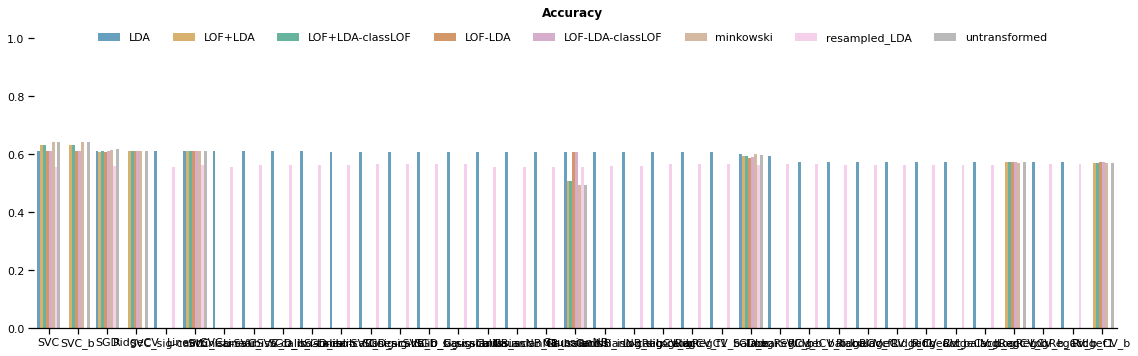

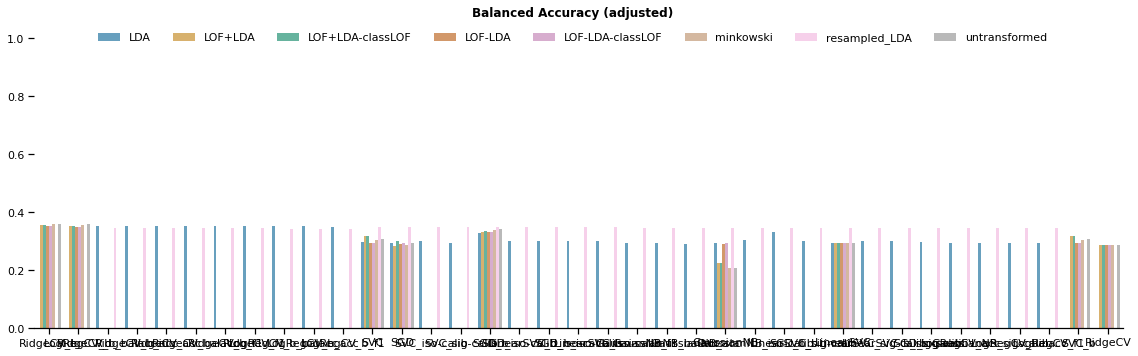

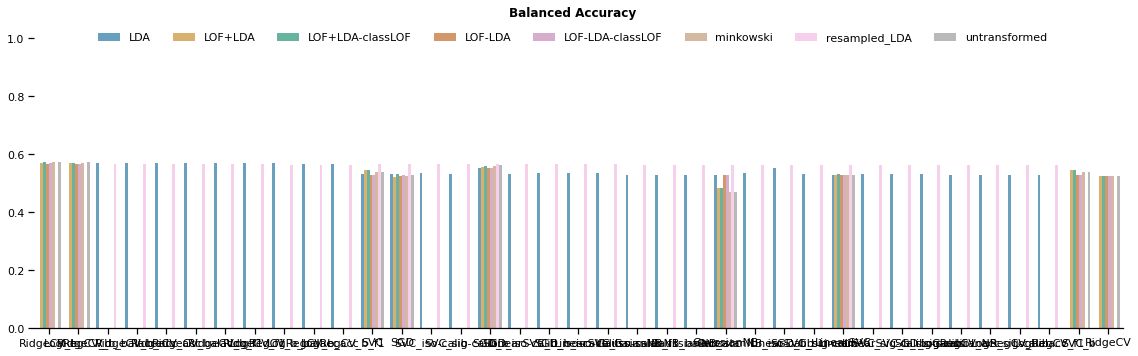

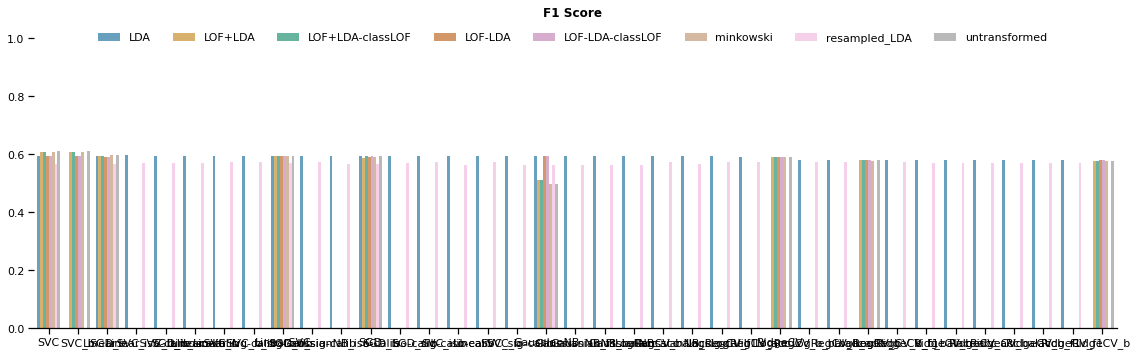

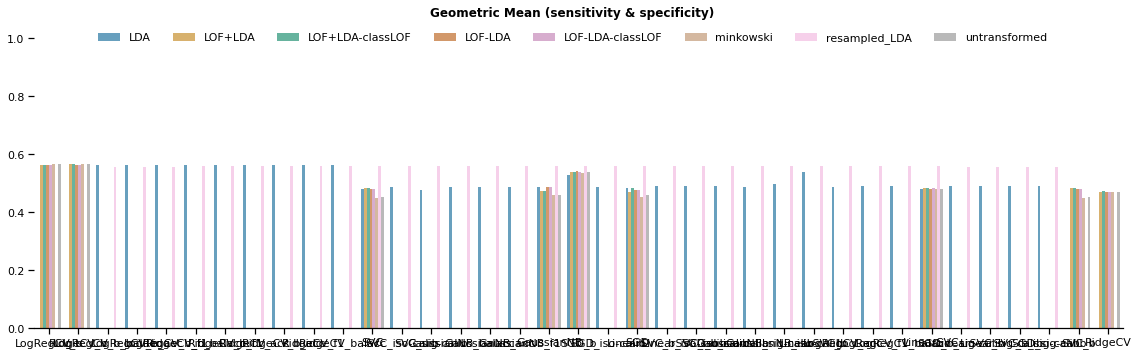

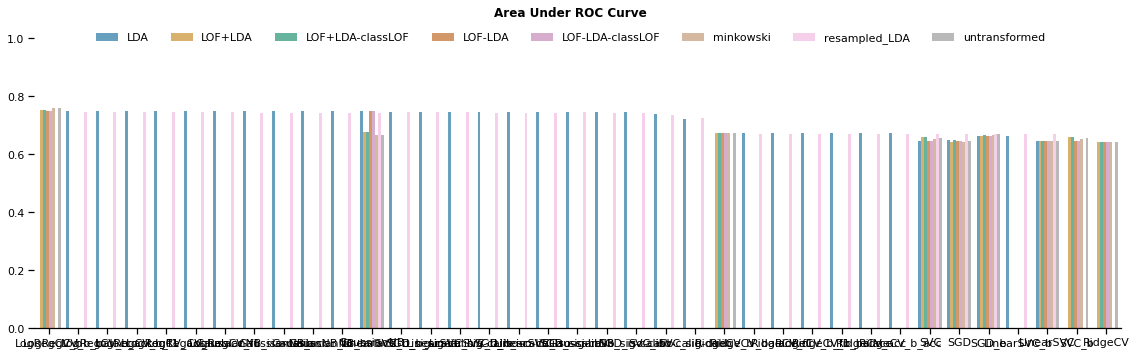

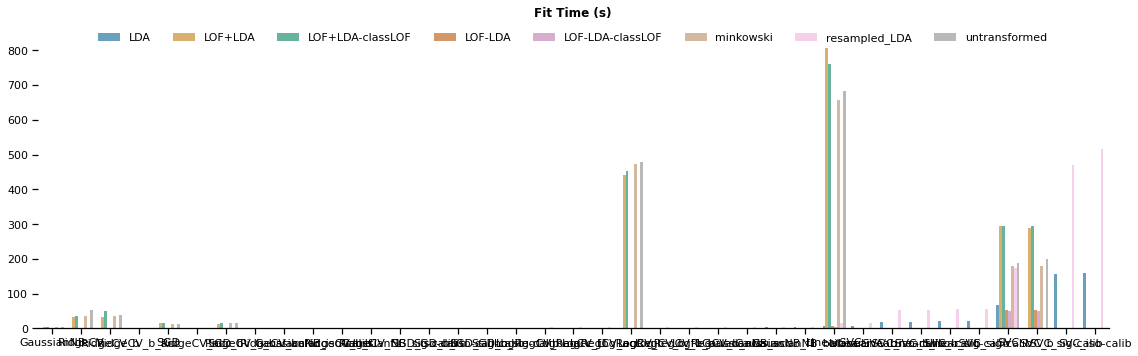

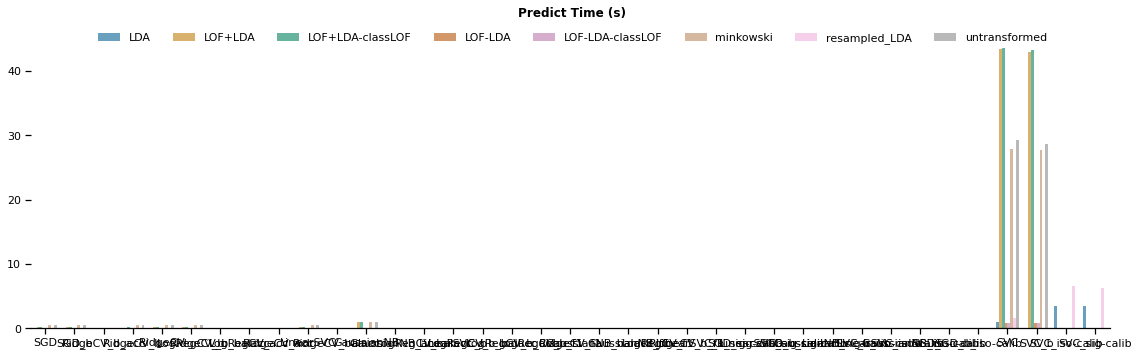

time: 16.7 s


In [16]:
for metric in tqdm(METRICS):
    plot_metric(metric, results_df)

# Discussion

Unfortunately, I overplotted above, but the results table .csv is pretty readable.

resampled_LDA was generally outperformed by LDA on the untransformed FRILL features. However, resampling before LDA provided a significant boost in balanced accuracy and geometric mean scores for some classifiers. Isotonic calibration was more successful for GaussianNB except when considering geometric mean on the resampled_LDA data.

GaussianNB most clearly benefits from LDA reduction. Other classifiers may perform better on the FRILL embeddings.

Global outlier removal before LDA extraction may improve the quality of the LDA components only for some classifiers by some metrics. Generally, estimators trained on LDA outperformed those trained on LOF-LDA, yet there are exceptions.

Calibration provides a noticeable bump in scores for certain classifiers. Fit times for SVC may be sensitive to the method of calibration.

Classification performance is generally better with more features, but handling the LDA features is much faster.

Some metrics like accuracy and balanced_accuracy appear to be inversely correlated.

Balanced accuracy rankings mirror adjusted balanced accuracy rankings, so only one of these needs to be considered in downstream analyses.

LogReg attains its highest accuracy and F1 scores with LDA. "balanced" class_weight works better for all metrics except F1 and accuracy. Although it performs better with more features, it is much slower.

It has been difficult for a single resampling method to work well in all scenarios. It is likely that resampling will need to be hypertuned as part of a pipeline. Although it is costly in time, it may be better than generating multiple copies of resampled data; at that rate, I'm more likely to run out of hard drive space. If possible, I'd prefer to resample after dimensionality reduction since this should be more agile.

Some classifiers just perform better with more data and more features and others may perform better on just the components. Classifiers obtain noticeably different scores when trained on data with different preprocessing steps.

The data is much more lightweight in two dimensions. Perhaps some clever feature engineering can help mitigate the drop in signal. Rescaling may still be necessary, but it'll be faster with fewer features.

Next steps should focus on feature engineering:
* extract one-class novelty features from FRILL embeddings with LOF
  * test some models on the LOF novelty trios (argmin of LOF) to make sure there is some value
* extract one-class probabilities with calibrated one-class SVCs using SGDOneClassSVM
  * the FRILL embeddings need to undergo Nystroem approximation
  * hopefully, we can get the benefits of SVC without actually having to train SVC on the FRILL embeddings this way
  * test some models on the one-class probability trios (argmax) to make sure there is some value
  * calibration parameters may need to be tuned
* combine LDA, LOF, and OCSVM features
  * test models with different scaling methods (maybe add random forest or other speedy algorithms back in)
  * if a single scaler looks best, pre-scale the splits
* (if features look good) hypertune including resampling pipe
  * export fitted models by fold
  



In [17]:
print(f"Time elapsed since notebook_begin_time: {time() - notebook_begin_time} s")
_ = gc_collect()

Time elapsed since notebook_begin_time: 10243.841361522675 s
time: 124 ms


[^top](#Contents)